# Credit Card Approval Prediction

## Here is the methods i will follow:

1. exploratory data analysis
2. Feature engineering
3. Feature selection
4. Data preprocessing
5. Model training
6. Model selection

### All necessary libraries
I imported all the required libraries that installed in the jupyter notebook environment.

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os
%matplotlib inline

### Import the data
The datasets are from Kaggle. Here is the [link](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)

In [2]:
cc_data_full_data = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/application_record.csv')
credit_status = pd.read_csv('https://raw.githubusercontent.com/semasuka/Credit-card-approval-prediction-classification/main/datasets/credit_record.csv')

In [3]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

In [4]:
credit_status.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

### Creating a target variable

I am building target variable that states whether the client is good or not (a client who will not default on their credit card would be called a good client). I am using  vintage analysis to build target variable and as a reference parameter using credit record.

Vintage analysis is a method used in finance, economics, and other fields to examine the performance or characteristics of a group of similar assets, liabilities, or data points based on the time they were originated or created, often referred to as their vintage.  This analysis can provide insights into factors such as default rates, prepayment speeds, and overall risk profiles associated with loans originated in different economic environments.

Note:The applicants over 60 days overdue are considered bad clients. When the target variable is 1, that means a bad client, and when it is 0, that represents a good client. That is what the following script does.



In [5]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg('min'))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status.loc[credit_status['STATUS'] =='2', 'dep_value'] = 'Yes'
credit_status.loc[credit_status['STATUS'] =='3', 'dep_value'] = 'Yes'
credit_status.loc[credit_status['STATUS'] =='4', 'dep_value'] = 'Yes'
credit_status.loc[credit_status['STATUS'] =='5', 'dep_value'] = 'Yes'
cpunt = credit_status.groupby('ID')['dep_value'].count().reset_index(name='dep_count')
cpunt['dep_value'] = np.where(cpunt['dep_count'] > 0, 'Yes', 'No')
cc_data_full_data = pd.merge(cc_data_full_data, cpunt[['ID', 'dep_value']], how='inner', on='ID')
cc_data_full_data['Is high risk'] = cc_data_full_data['dep_value'].map({'Yes': 1, 'No': 0})
cc_data_full_data.drop('dep_value', axis=1, inplace=True)
pd.options.mode.chained_assignment = None


In [6]:
cc_data_full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0             NaN   
1               1                1           0           0             NaN   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0  


I change columns name

In [7]:
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [8]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0

Now i will split the cc_data_full_data into a training and testing set. I will use 80% of the data for training and 20% for testing and store them respectively in cc_train_original and cc_test_original variables.

In [9]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0

In [10]:
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [12]:
cc_train_original.shape

(29165, 20)

In [13]:
cc_test_original.shape

(7292, 20)

Exporting the data as a CSV file on our local machine and create a copy of the dataset.

In [14]:
cc_train_original.to_csv('train.csv',index=False)

In [15]:
cc_test_original.to_csv('test.csv',index=False)

In [16]:
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [17]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0

In [18]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

The describe() function gives statistics about the numerical features in the dataset. These statistics include each numerical feature’s count, mean, standard deviation, interquartile range(25%, 50%, 75%), and minimum and maximum values.

In [19]:
cc_data_full_data.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  Is high risk  
count  36457.000000         36457.000000  36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193      0.016897  
std        0.285787             0.911686     16.501854      0.128886  
min        0.000000             1.000000    -60.000000      0.000000  
25%        0.000000             2.000000    -39.000000      0.000000  
50%        0.000000             2.000000    -24.000000      0.000000  
75%        0.000000             3.000000    -12.000000      0.000000  
max        1.000000            20.000000      0.000000      1.000000

I am using Missingno to visualize the missing values per feature using its matrix and i have seen above with info() only JOB TITLE has not complete data

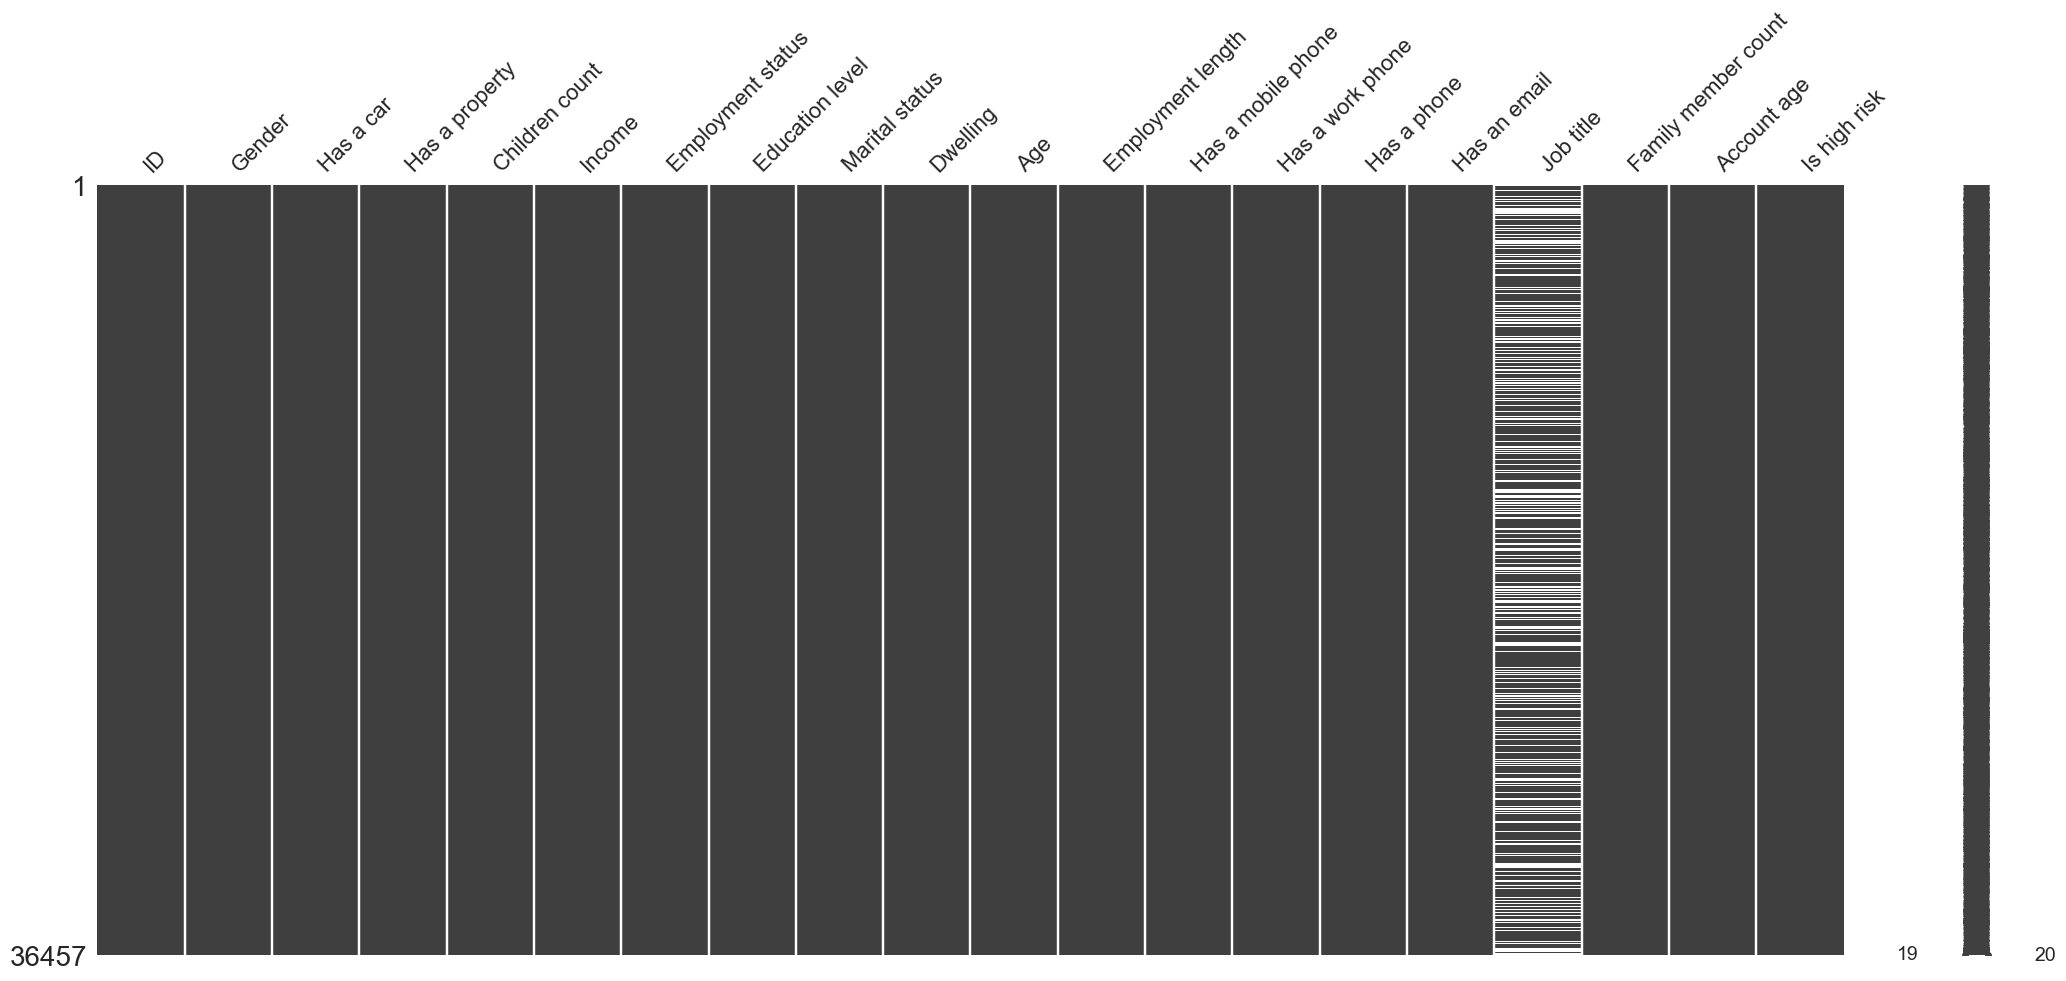

In [20]:
msno.matrix(cc_data_full_data)
plt.show()

Here i can see that the Job title is the only feature with missing values. Slim white lines represent missing values.

To see a clear representation of the missing values count, i am using its bar() function to have a barplot with the count of non-null values.

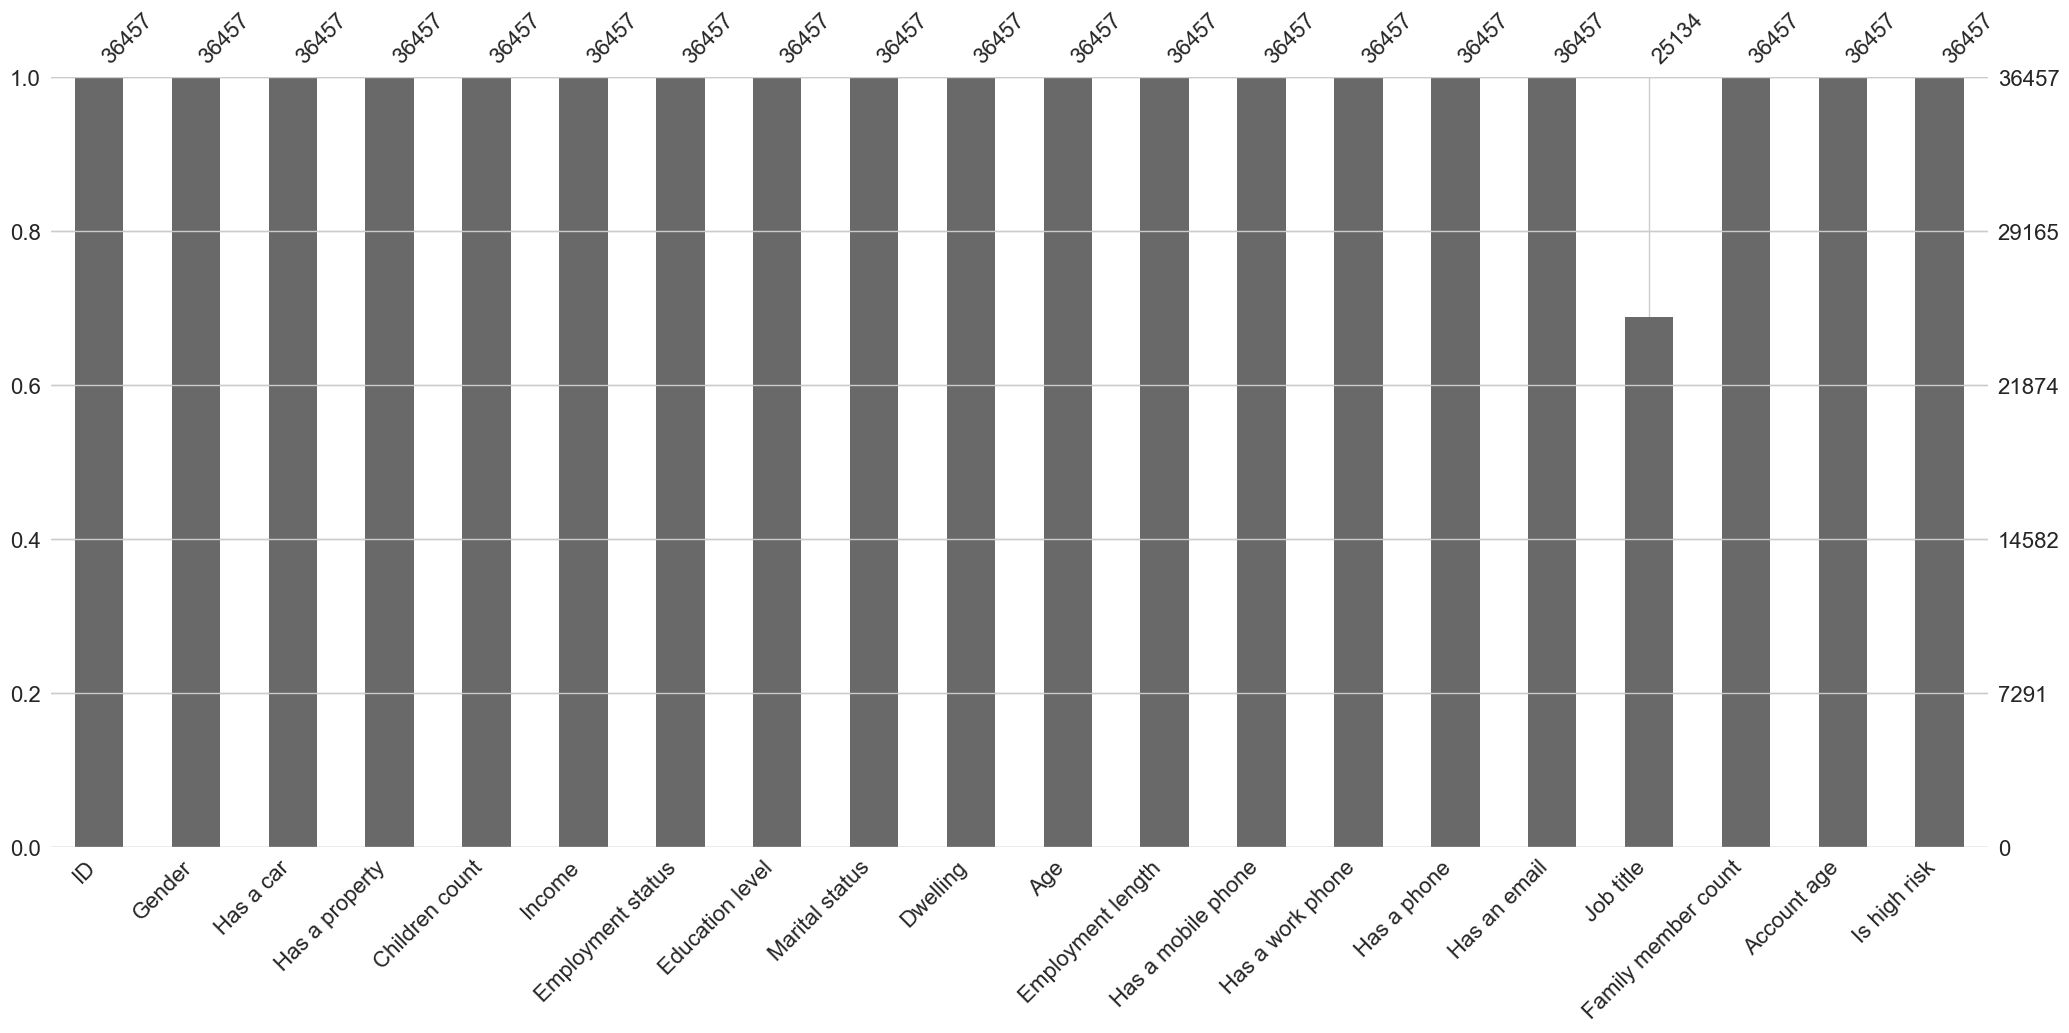

In [21]:
msno.bar(cc_data_full_data)
plt.show()

Now i am creating functions to analyze each feature(Univariate analysis).

My first function value_cnt_norm_cal is used to calculate the count of each class in a feature with its frequency (normalized on a scale of 100).

In [22]:
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### gen_info_feat returned the DESCRIPTION, the DATATYPE, STATISTICS, the VALUE COUNTS and FREQUENCIES.
Note: I have used the if statement to handle features differently depending on their data type and characteristics. For example, I divided age by 365.25 and changed it to a positive value because it is expressed in days instead of years. Same as employment length; however, we did not print the value count for account age.

Function to display general information about the feature

In [23]:
def gen_info_feat(df,feature):
    if feature == 'Age':
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    if feature == 'Employment length':
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    if feature == 'Account age' or feature == 'Income':
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))

### The following function prints a pie chart.

A pie chart is a circular statistical graphic that is divided into slices to illustrate numerical proportions. Each slice represents a proportionate part of the whole, and the size of each slice is proportional to the quantity it represents. Pie charts are commonly used to show the distribution of a categorical variable or the relative sizes of different categories within a dataset.

In [24]:
def create_pie_plot(df,feature):
    if feature == 'Dwelling' or feature == 'Education level':
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')

        return plt.show()
    else:
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

### The next function create a bar plot.
A bar plot (or bar chart) is a type of chart that represents categorical data with rectangular bars. The length or height of each bar corresponds to the frequency, count, or proportion of data in each category. Bar plots are used to visualize and compare the values of different categories or groups within a dataset.

In [25]:
def create_bar_plot(df,feature):
    if feature == 'Marital status' or feature == 'Dwelling' or feature == 'Job title' or feature == 'Employment status' or feature == 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

### This function will create a box plot for continuous variables.
A box plot, also known as a box-and-whisker plot, is a graphical representation of the distribution of a continuous variable through five key summary statistics: minimum, first quartile (Q1), median (Q2), third quartile (Q3), and maximum.

#### Note:Depending on which transformation needs to be done on each feature, we have used a switch statement to handle the different feature that requires different handling.

In [26]:
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    if feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    if feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

### This function will plot a histogram.
Plotting a histogram involves visualizing the distribution of a continuous variable by dividing the data into intervals or bins and displaying the frequency or count of observations within each interval using bars.

In [27]:
def create_hist_plot(df,feature, the_bins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    if feature == 'Account age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

This function will plot two box plots, one is for low-risk (good client), and the other is for high-risk (bad client) applicants.

In [28]:
def low_high_risk_box_plot(df,feature):
    if feature == 'Age':
        print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    if feature == 'Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    if feature == 'Employment length':
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else:
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

This function is similar to the previous one; the only difference is that it uses a bar plot which is a count of classes for comparison purposes between high risk and low risk.

In [29]:
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

### Univariate analysis
Univariate analysis is an analysis of each feature individually in the dataset.

### Gender

In [30]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       19549      67.028973
M        9616      32.971027


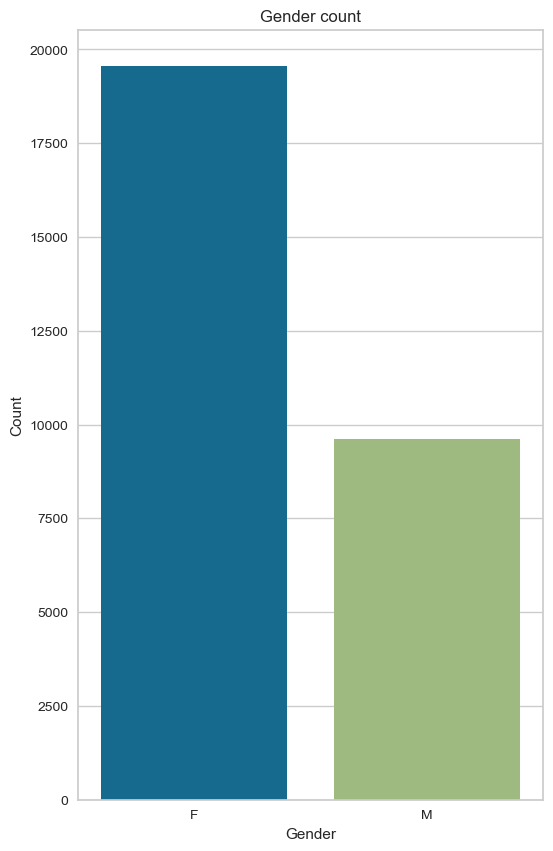

In [31]:
create_bar_plot(cc_train_copy,'Gender')

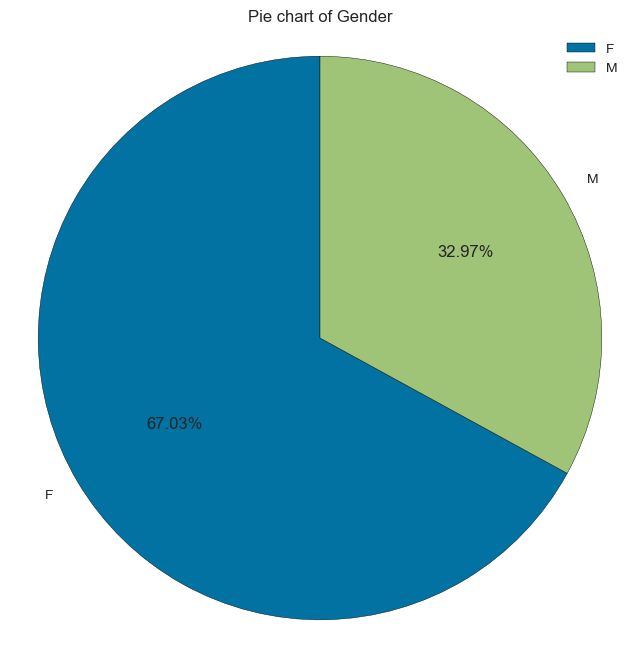

In [32]:
create_pie_plot(cc_train_copy,'Gender')

### Age
Now let’s look at Age; since age is a continuous variable, I will process it differently than Gender. Using the gen_info_feat function, i can see at the mean, standard deviation, minimum, maximum and interquartile range. Then i plot that information on a box plot by calling the create_box_plot function. With that, i can see that the youngest applicant(s) is 21 years old while the oldest is 68. With an average of 43.7 and a median of 42.6.

In [33]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.000000
mean    -15979.477490
std       4202.997485
min     -25152.000000
25%     -19444.000000
50%     -15565.000000
75%     -12475.000000
max      -7705.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
Age                         
-12676     44       0.150866
-15519     44       0.150866
-16896     33       0.113149
-16053     26       0.089148
-16768     26       0.089148
...       ...            ...
-18253      1       0.003429
-23429      1       0.003429
-15478      1       0.003429
-21648      1       0.003429
-19564      1      

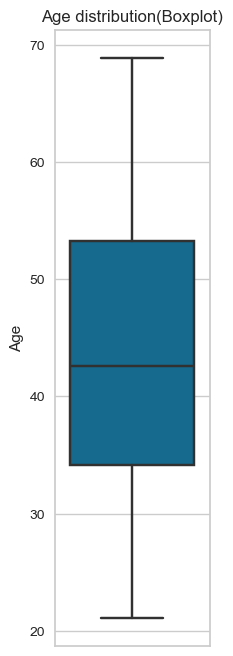

In [34]:
create_box_plot(cc_train_copy,'Age')

After that, we plot its histogram with the kernel density estimator. ``` Age `` is not normally distributed; it is slightly positively skewed.

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


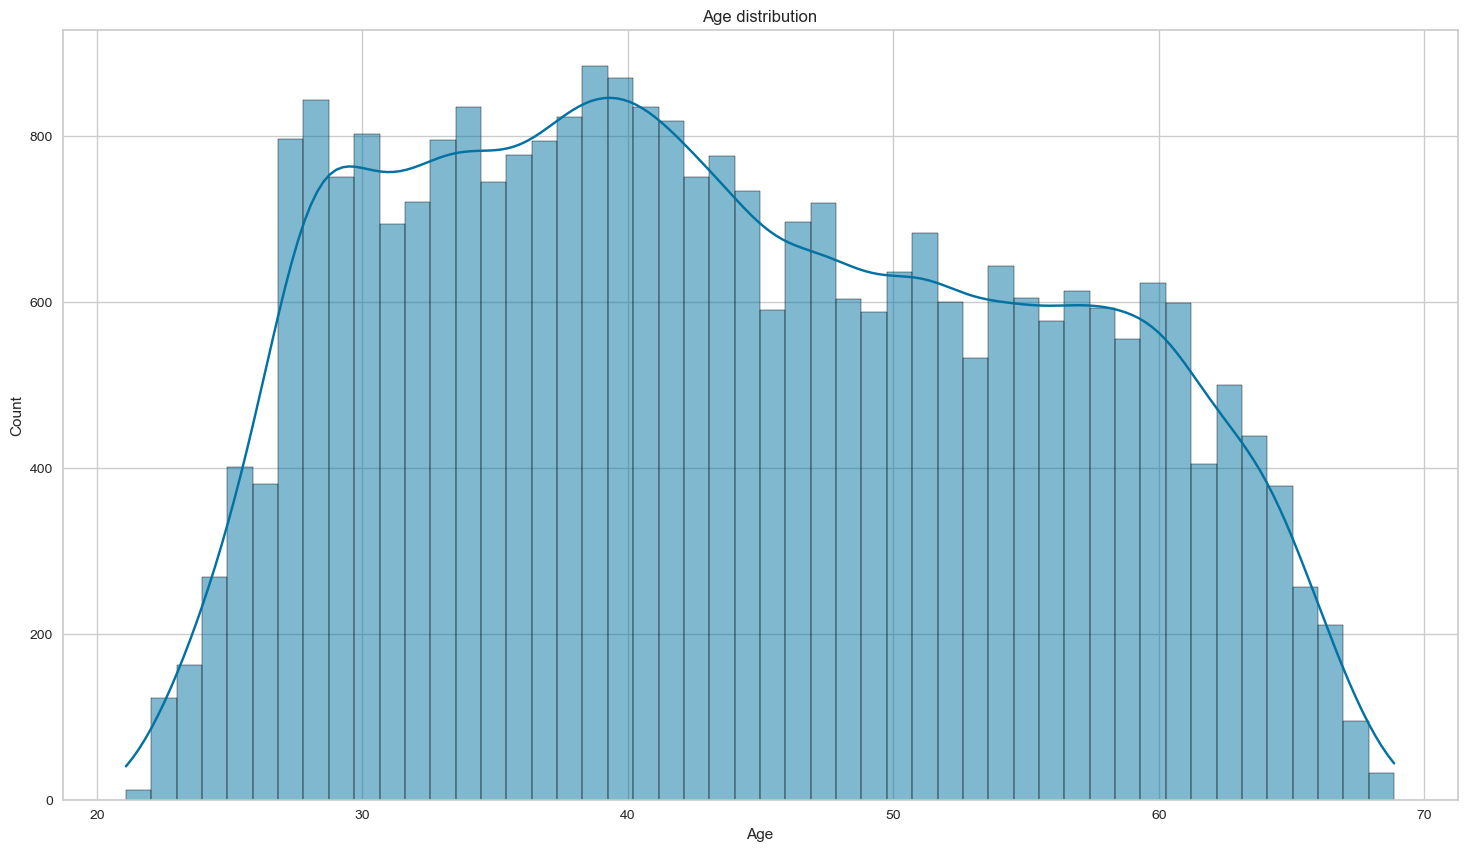

In [35]:
create_hist_plot(cc_train_copy,'Age')

Now i perform a quick bivariate analysis (comparison of two features) of Age and the target variable Is high risk. The blue box plot represents a good client (is high risk = No), and the green box plot represents a bad client (is high risk = Yes). I can see no significant difference between the age of those who are high risk and those who are not. The mean age for both groups is around 43 years old, and there is no correlation between the age and risk factors of the applicant.

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


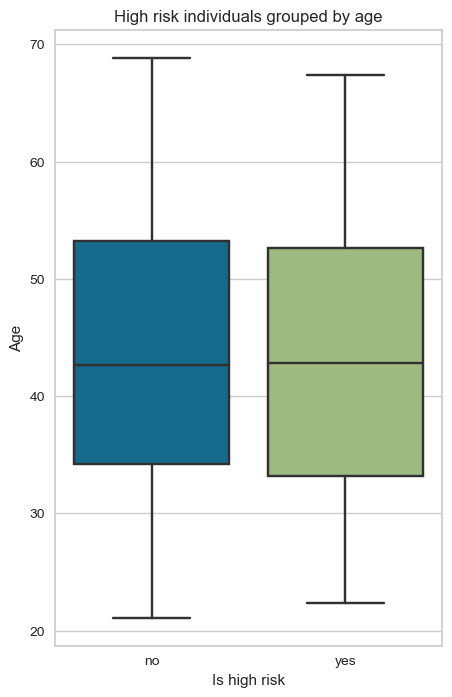

In [36]:
low_high_risk_box_plot(cc_train_copy,'Age')

### Marital status
There are 5 unique classes for this feature. Married constitutes the most significant proportion of marital status, with 68% far ahead of single, as seen on the pie chart and bar charts. Another interesting observation is that even though we have a higher number of applicants who are separated than widows, it seems that widow applicants are bad clients than those who are separated by a small margin.

In [37]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Marital status                            
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


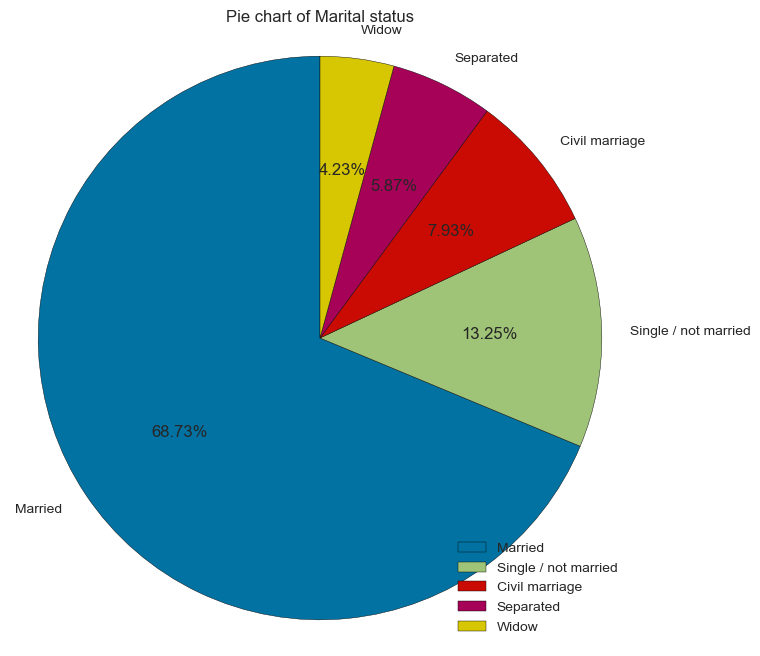

In [38]:
create_pie_plot(cc_train_copy,'Marital status')

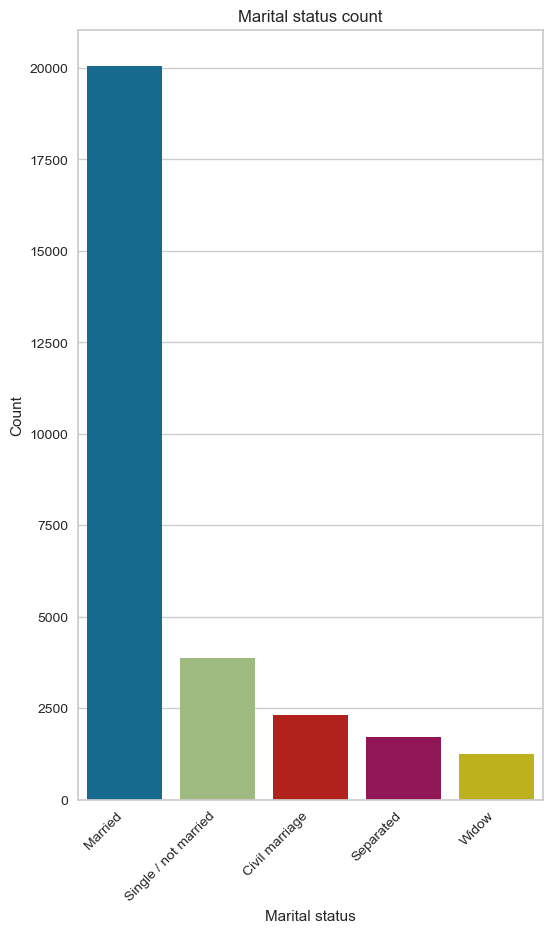

In [39]:
create_bar_plot(cc_train_copy,'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


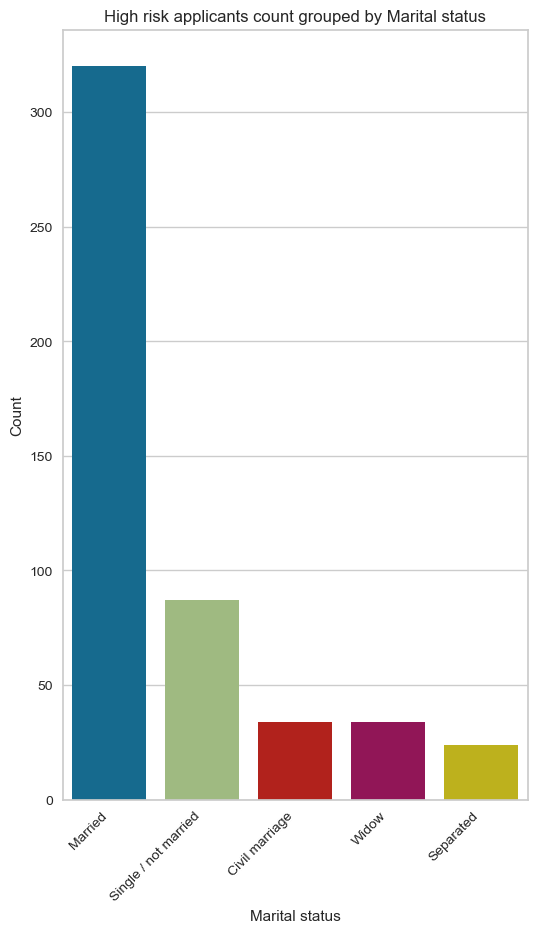

In [40]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

### Family member count
Family member count is a numerical feature, with the median of 2 family members representing 53% (count = 15552) of all the counts, followed by a single family member with 19% (count = 5613). Looking at the box plot, we have 6 outliers; 2 are extreme, with 20 and 15 members in their household.

In [41]:
gen_info_feat(cc_train_copy,'Family member count')

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                     Count  Frequency (%)
Family member count                      
2.0                  15552      53.324190
1.0                   5613      19.245671
3.0                   5121      17.558718
4.0                   2503       8.582205
5.0                    309       1.059489
6.0                     48       0.164581
7.0                     14       0.048003
9.0                      2       0.006858
15.0                     2       0.006858
20.0                     1       0.003429


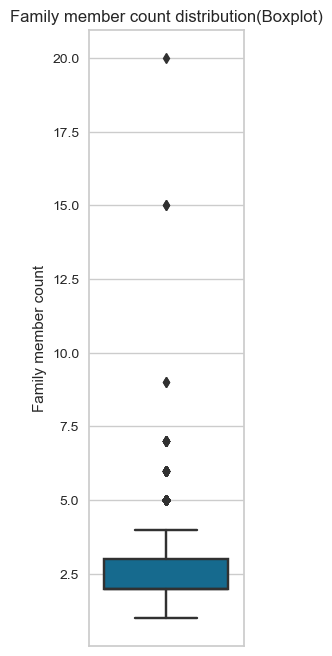

In [42]:
create_box_plot(cc_train_copy,'Family member count')

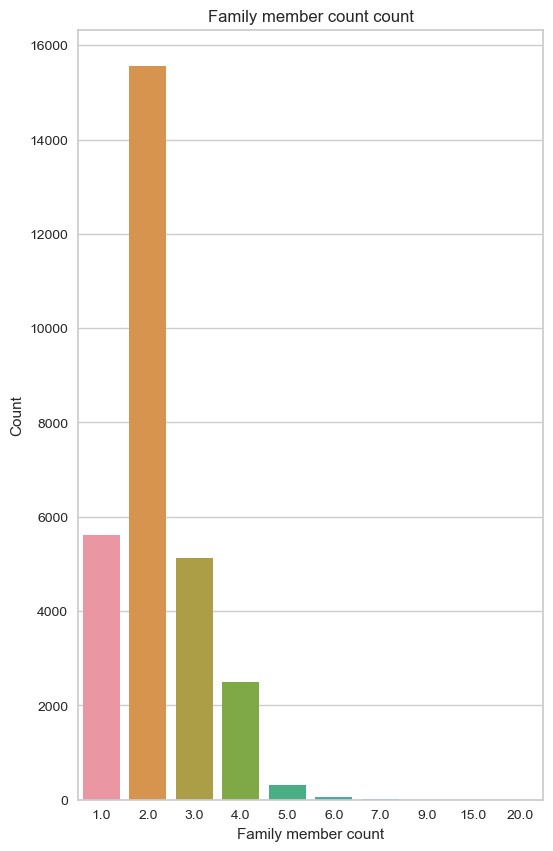

In [43]:
create_bar_plot(cc_train_copy,'Family member count')

### Children count
From the chart below, i can see that most applicants don’t have any children. Again, i have 6 outliers, most probably the same seen from the family member count.

In [44]:
gen_info_feat(cc_train_copy,'Children count')

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                Count  Frequency (%)
Children count                      
0               20143      69.065661
1                6003      20.582890
2                2624       8.997086
3                 323       1.107492
4                  52       0.178296
5                  15       0.051432
7                   2       0.006858
14                  2       0.006858
19                  1       0.003429


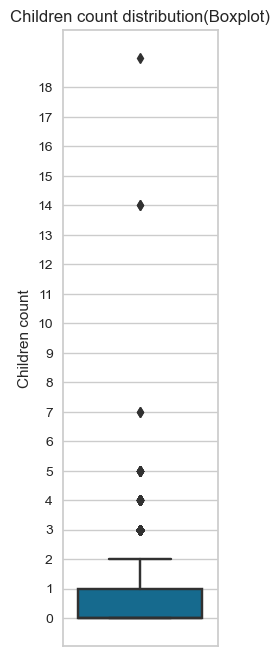

In [45]:
create_box_plot(cc_train_copy,'Children count')

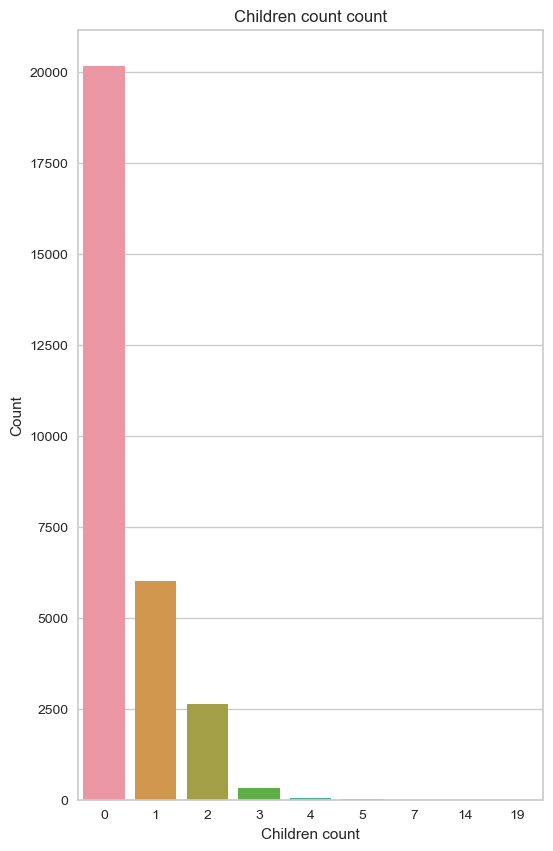

In [46]:
create_bar_plot(cc_train_copy,'Children count')

### Dwelling type
89% of applicants live in houses/apartments by a substantial margin.

In [47]:
gen_info_feat(cc_train_copy,'Dwelling')

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
Dwelling                                 
House / apartment    26059      89.350249
With parents          1406       4.820847
Municipal apartment    912       3.127036
Rented apartment       453       1.553232
Office apartment       208       0.713184
Co-op apartment        127       0.435453


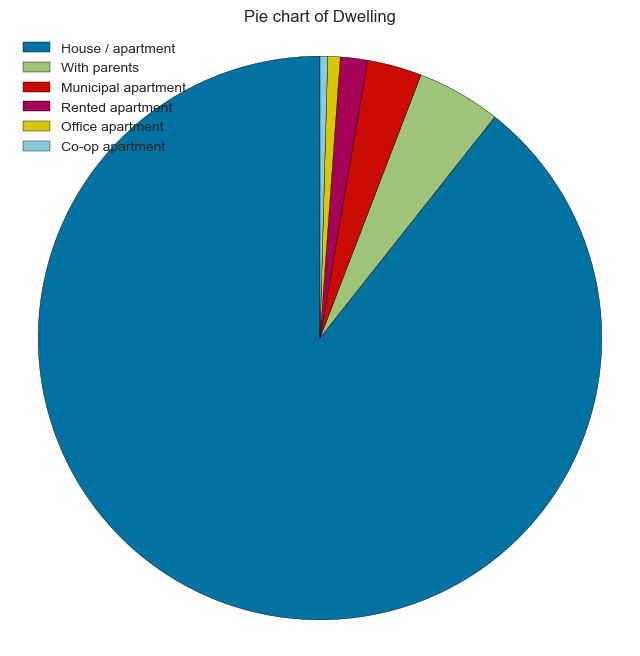

In [48]:
create_pie_plot(cc_train_copy,'Dwelling')

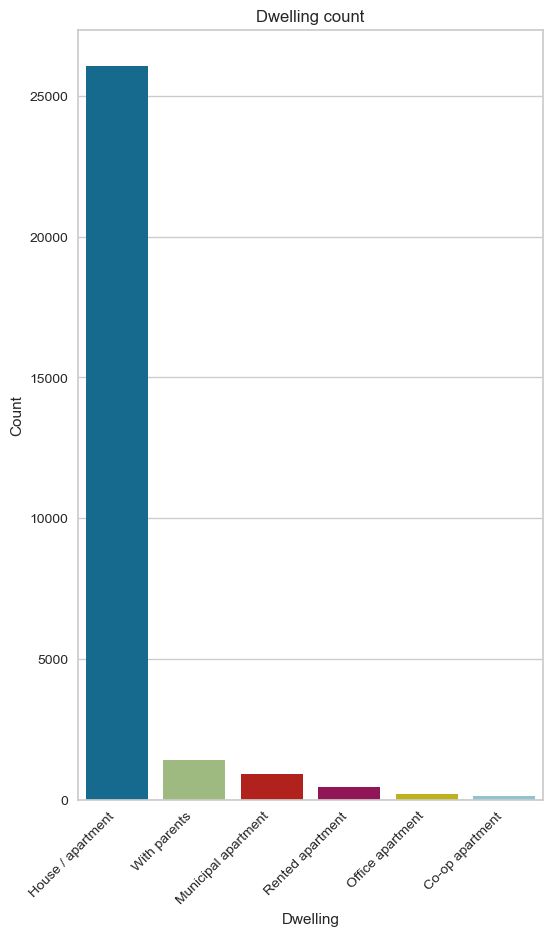

In [49]:
create_bar_plot(cc_train_copy,'Dwelling')

### Income
Looking at the results from the gen_info_feat function, i can see that the average mean income is 186890, but this amount factors in outliers. Most people make 157500 (median income) if we ignore the outliers. We have 3 applicants who make more than 1000000.

This feature is also positively skewed. Focusing on the income box plot of good and bad clients, they all have roughly similar incomes.

In [50]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

Description:
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:float64


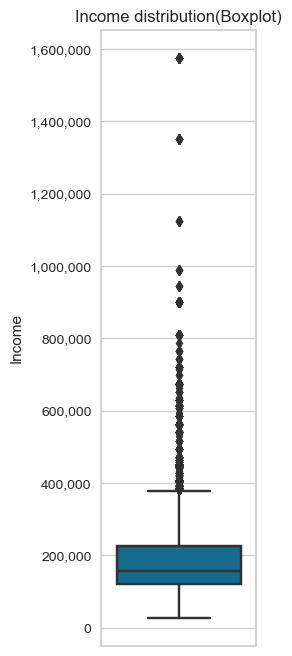

In [51]:
create_box_plot(cc_train_copy,'Income')

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


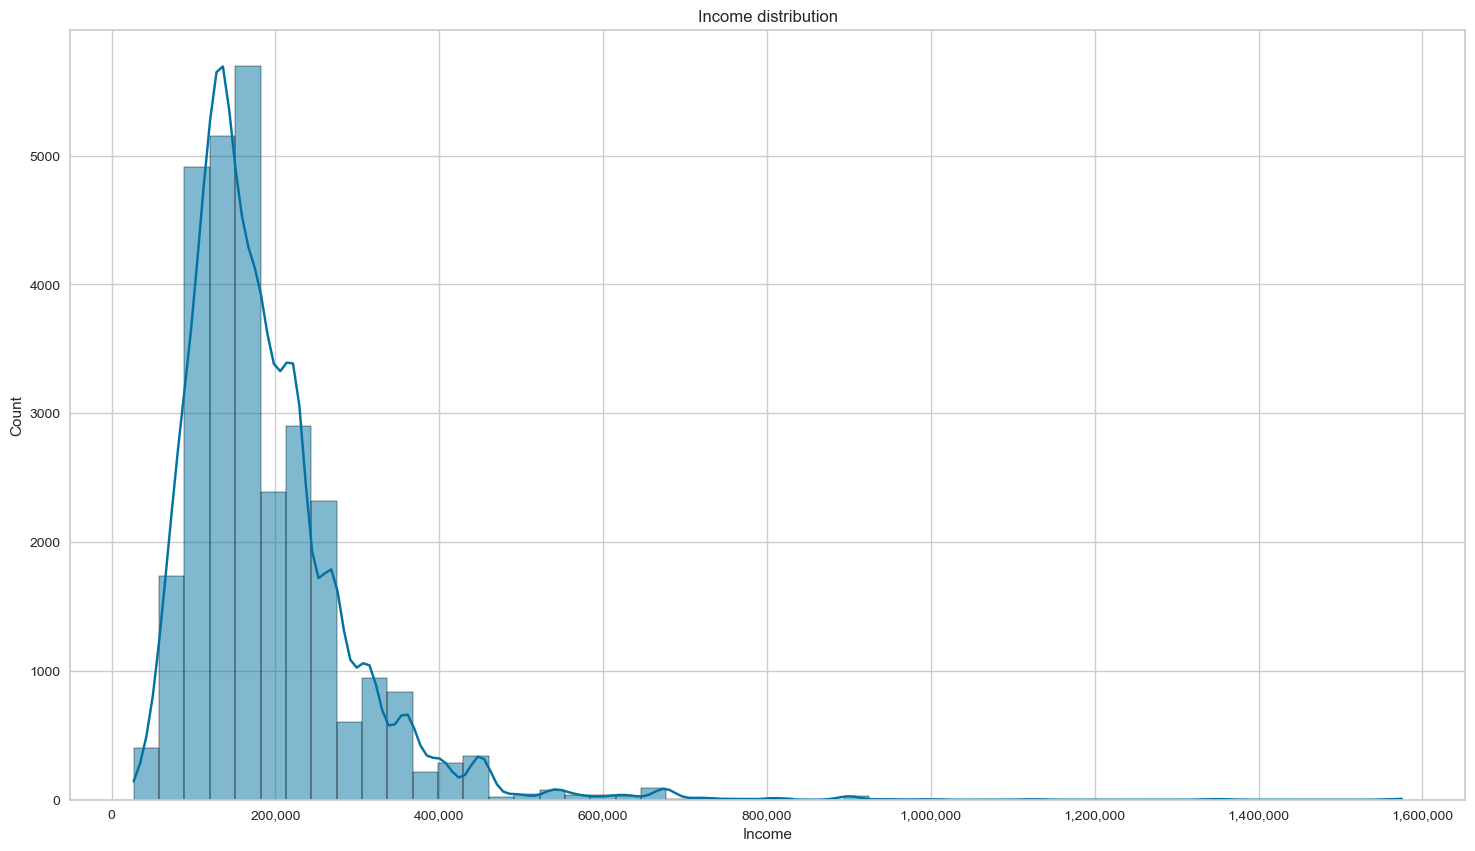

In [52]:
create_hist_plot(cc_train_copy,'Income')

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


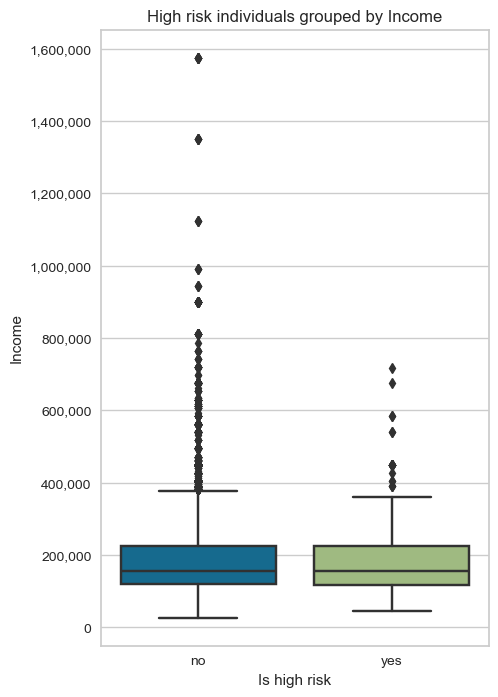

In [53]:
low_high_risk_box_plot(cc_train_copy,'Income')

### Job title
The most common Job title is laborers by a large margin (24.85%), followed by core staff (14.23%), sales staff (13.77%) and managers (12.03%), also have 30.95% of missing data.

In [54]:
gen_info_feat(cc_train_copy,'Job title')

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Job title                                  
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122           0.

cc_train_copy['Job title'].isna(): This part of the code selects the 'Job title' column from the DataFrame cc_train_copy and then applies the isna() method, which returns a boolean mask indicating whether each value in the column is missing (NaN) or not. The result is a Series of boolean values.
.sum(): This method is then applied to the boolean Series obtained from the previous step. It calculates the sum of all True values in the Series, where True corresponds to missing values (NaNs).

In [55]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

9027

In [56]:
rows_total_count = cc_train_copy.shape[0]

In [57]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


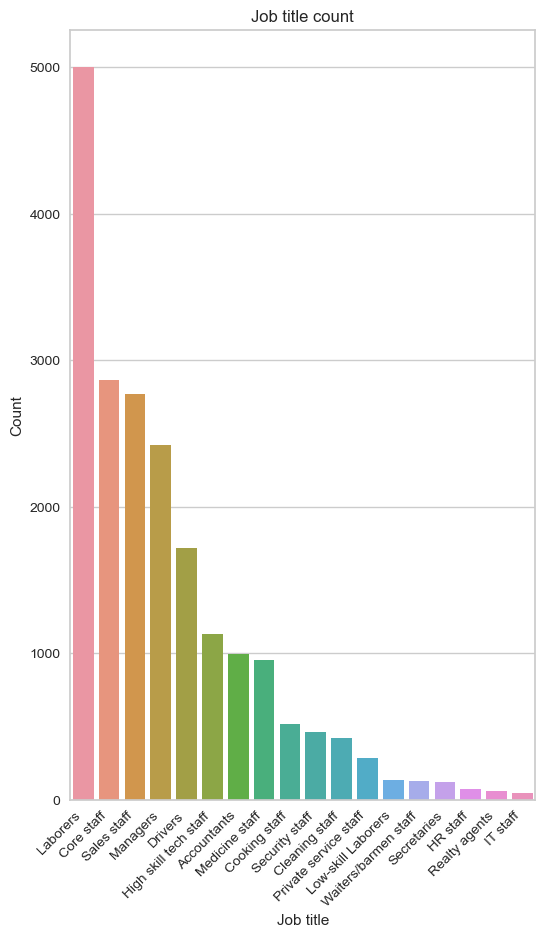

In [58]:
create_bar_plot(cc_train_copy,'Job title')

### Employment status

Most applicants are working (51.62%); the next most represented status is commercial associate, followed by the pensioner.

In [59]:
gen_info_feat(cc_train_copy,'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Employment status                         
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


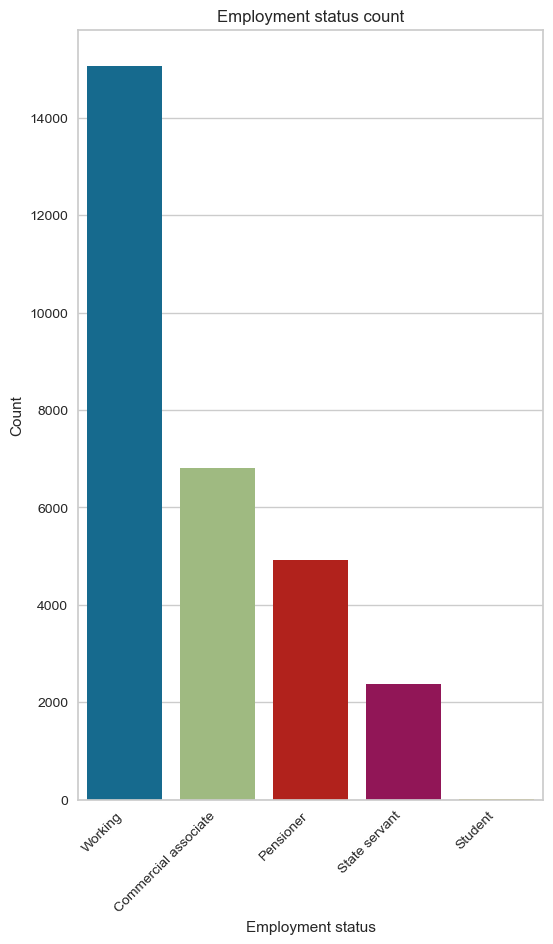

In [60]:
create_bar_plot(cc_train_copy,'Employment status')

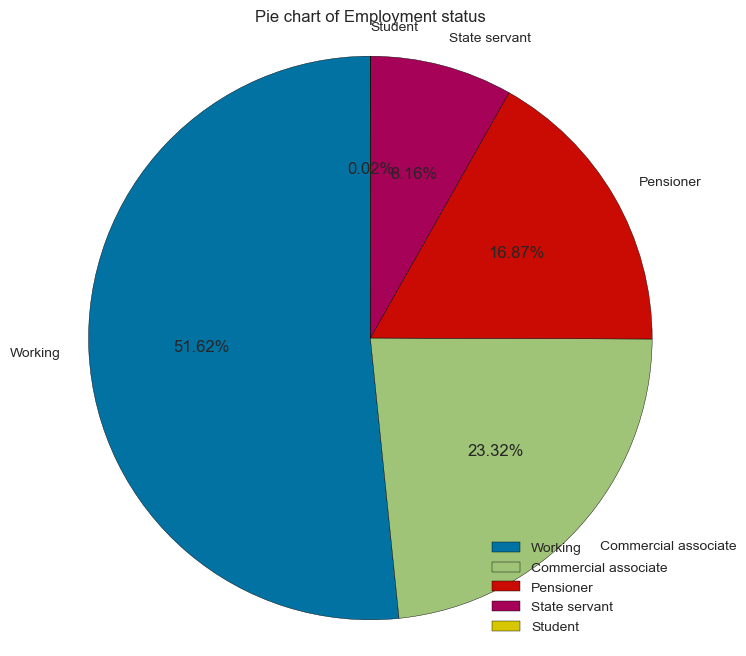

In [61]:
create_pie_plot(cc_train_copy,'Employment status')

### Education level
Most applicants have completed their secondary degree (67.90%) ¼ completed their higher education.

In [62]:
gen_info_feat(cc_train_copy,'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


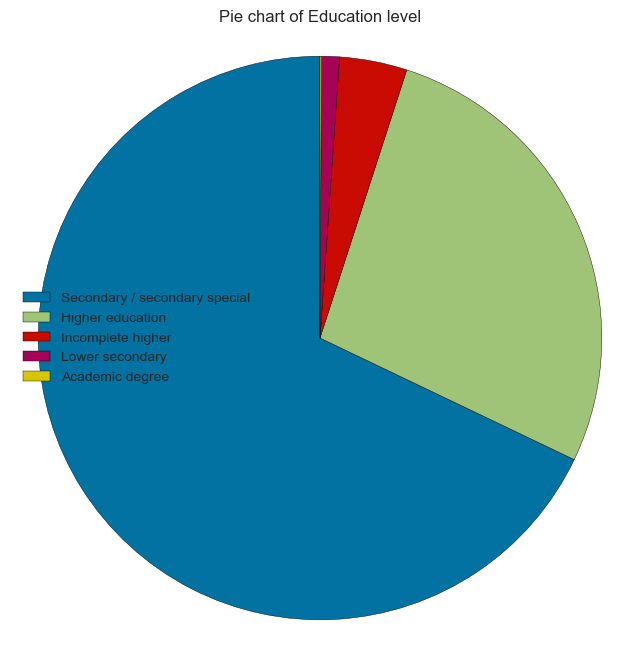

In [63]:
create_pie_plot(cc_train_copy,'Education level')

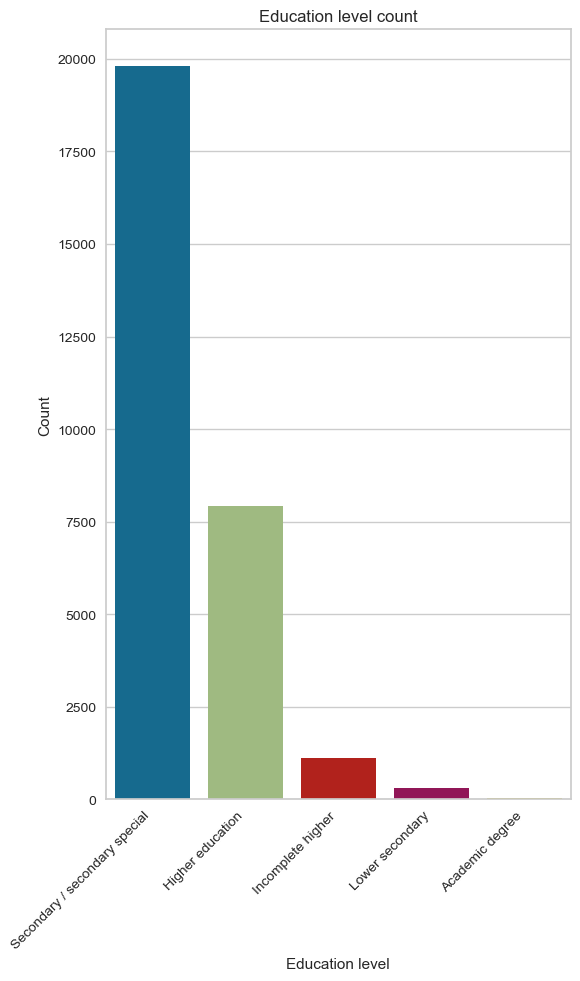

In [64]:
create_bar_plot(cc_train_copy,'Education level')

### Employment length
Most applicants have been working between 5 to 7 years on average, and also have many outliers who have been working for more than 20 years+. The employment length histogram is positively skewed. Finally, bad clients have a low employment length of 5 versus 7 years for good clients.

In [65]:
gen_info_feat(cc_train_copy,'Employment length')

Description:
count   24257.00
mean        7.26
std         6.46
min         0.05
25%         2.68
50%         5.45
75%         9.60
max        43.02
Name: Employment length, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.00
mean     59257.76
std     137655.88
min     -15713.00
25%      -3153.00
50%      -1557.00
75%       -412.00
max     365243.00
Name: Employment length, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                   Count  Frequency (%)
Employment length                      
 365243             4908          16.83
-401                  61           0.21
-200                  55           0.19
-2087                 53           0.18
-1539                 51           0.17
...                  ...            ...
-8369                  1           0.00
-6288                  1           0.00
-6303      

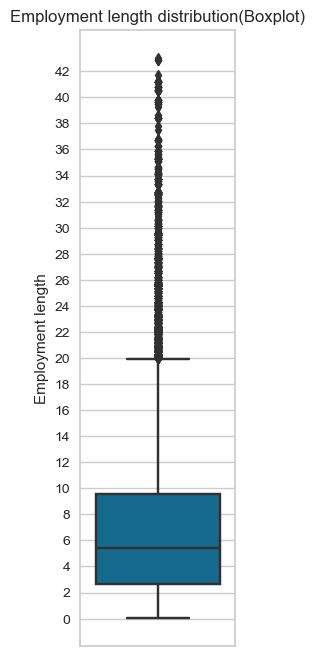

In [66]:
create_box_plot(cc_train_copy,'Employment length')

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


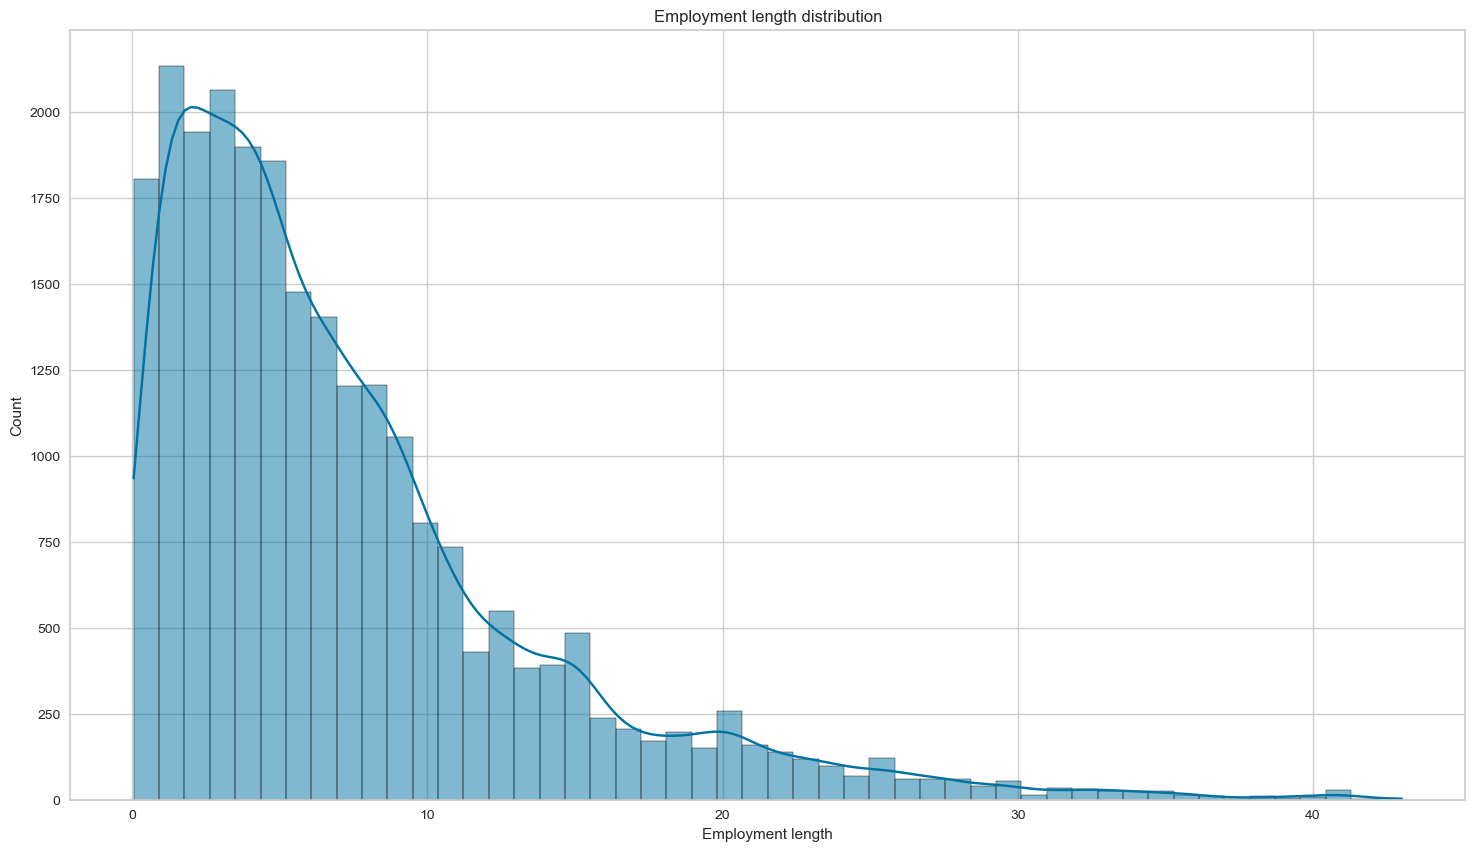

In [67]:
create_hist_plot(cc_train_copy,'Employment length')

bivariate analysis with target variable

Is high risk
0   7.29
1   5.75
Name: Employment length, dtype: float64


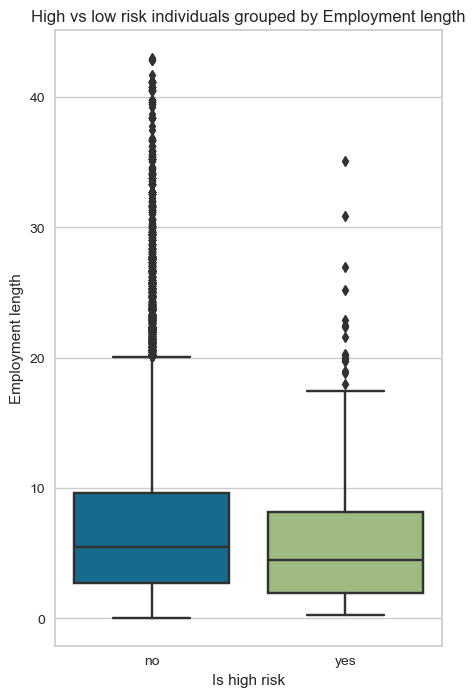

In [68]:
low_high_risk_box_plot(cc_train_copy,'Employment length')

### Has a car
Most applicants don’t own a car (62% of applicants).

In [69]:
gen_info_feat(cc_train_copy,'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
           Count  Frequency (%)
Has a car                      
N          18128          62.16
Y          11037          37.84


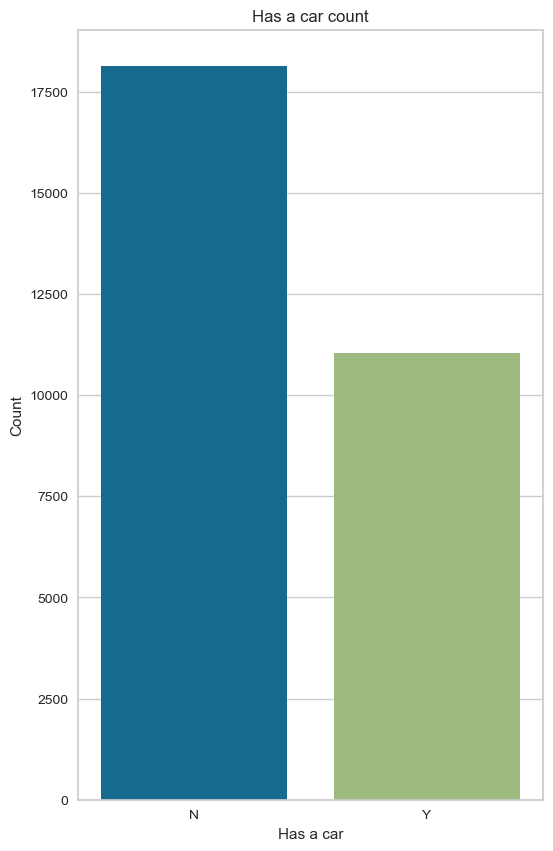

In [70]:
create_bar_plot(cc_train_copy,'Has a car')

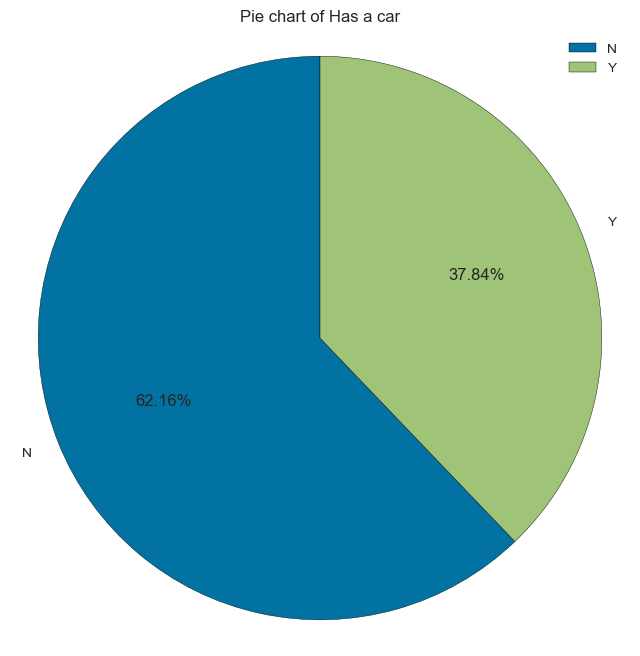

In [71]:
create_pie_plot(cc_train_copy,'Has a car')

### Has a property
Most applicants own a property (67% of applicants)

In [72]:
gen_info_feat(cc_train_copy,'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Has a property                      
Y               19557          67.06
N                9608          32.94


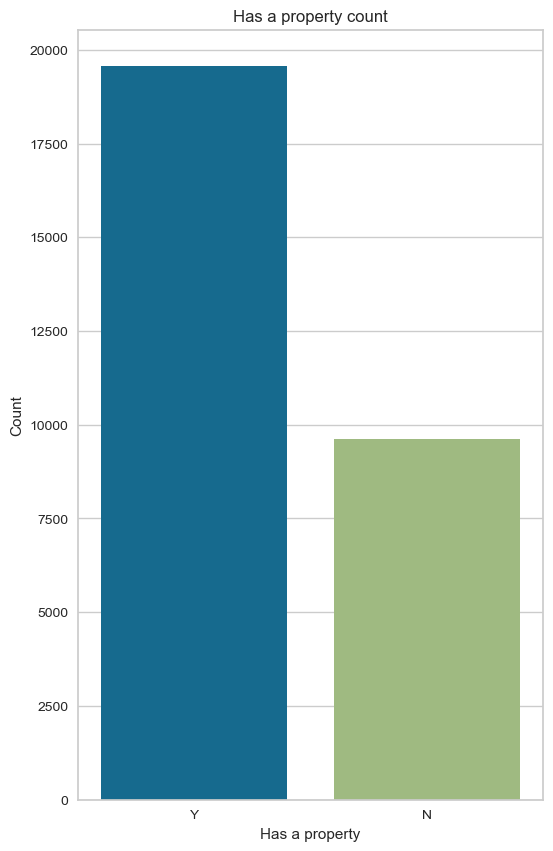

In [73]:
create_bar_plot(cc_train_copy,'Has a property')

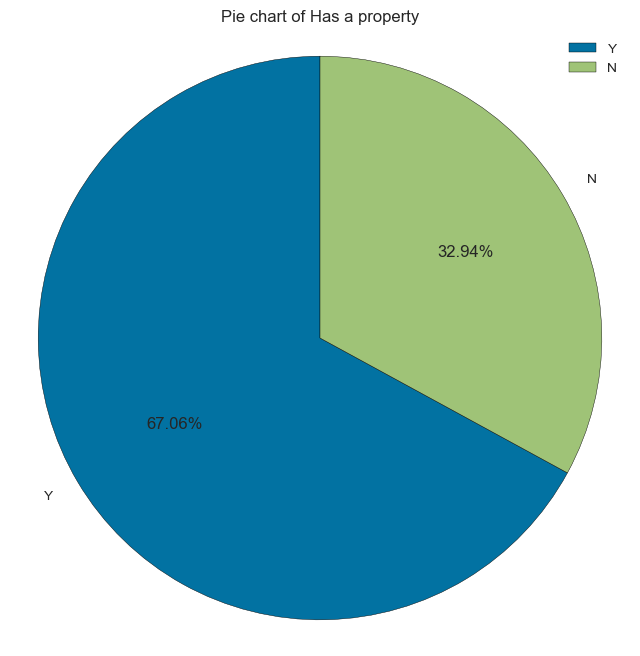

In [74]:
create_pie_plot(cc_train_copy,'Has a property')

### Has a work phone
More than ¾ of applicants don’t have a work phone

Note: Here, 0 represent no and 1 represents yes

In [75]:
gen_info_feat(cc_train_copy,'Has a work phone')

Description:
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
Has a work phone                      
0                 22623          77.57
1                  6542          22.43


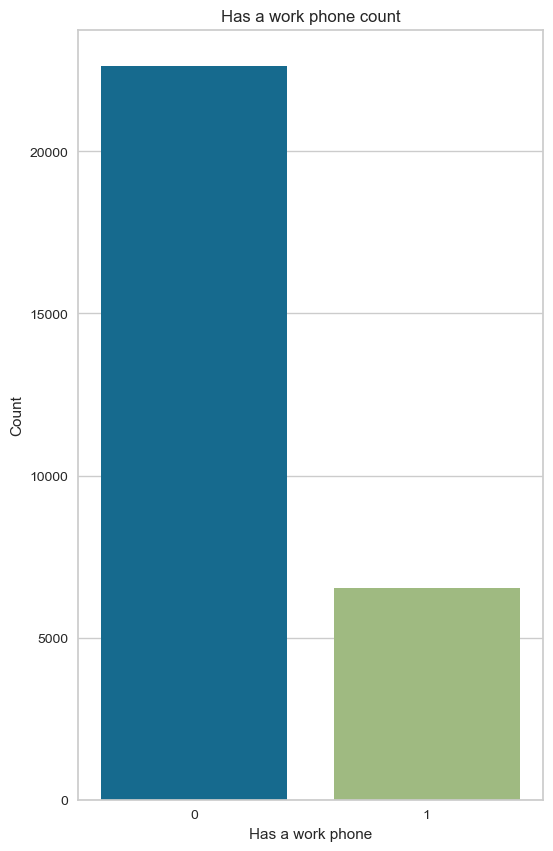

In [76]:
create_bar_plot(cc_train_copy,'Has a work phone')

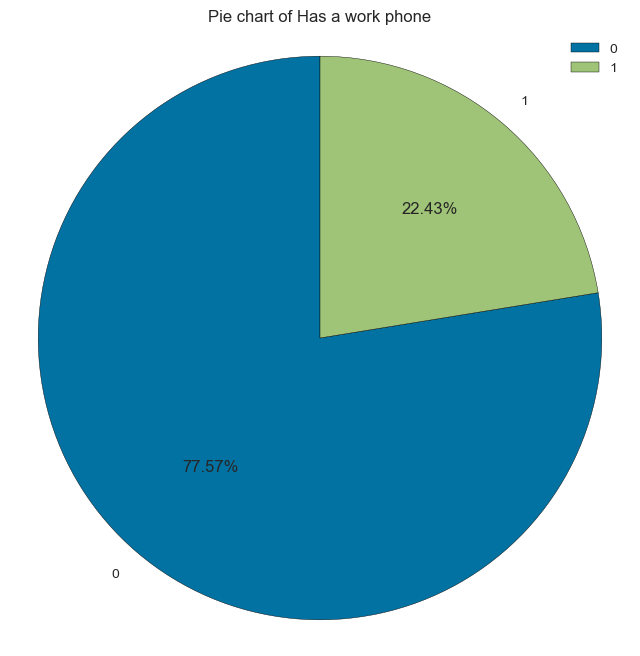

In [77]:
create_pie_plot(cc_train_copy,'Has a work phone')

### Has a mobile phone
All the applicants, without exception, have a mobile phone.

Note: Here, 0 is no and 1 is yes

In [78]:
gen_info_feat(cc_train_copy,'Has a mobile phone')

Description:
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                    Count  Frequency (%)
Has a mobile phone                      
1                   29165         100.00


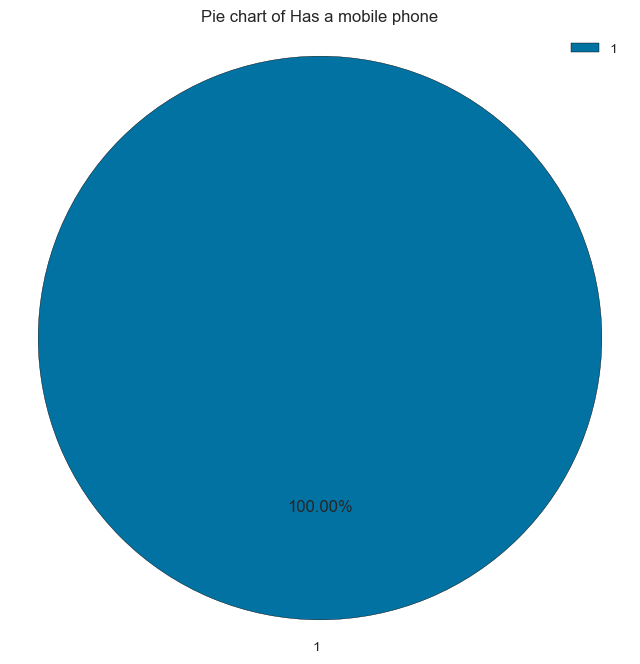

In [79]:
create_pie_plot(cc_train_copy,'Has a mobile phone')

### Has a phone
70% of applicants don’t have a phone (probably a home phone)

Note: Here, 0 is no and 1 is yes

In [80]:
gen_info_feat(cc_train_copy,'Has a phone')

Description:
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
             Count  Frequency (%)
Has a phone                      
0            20562          70.50
1             8603          29.50


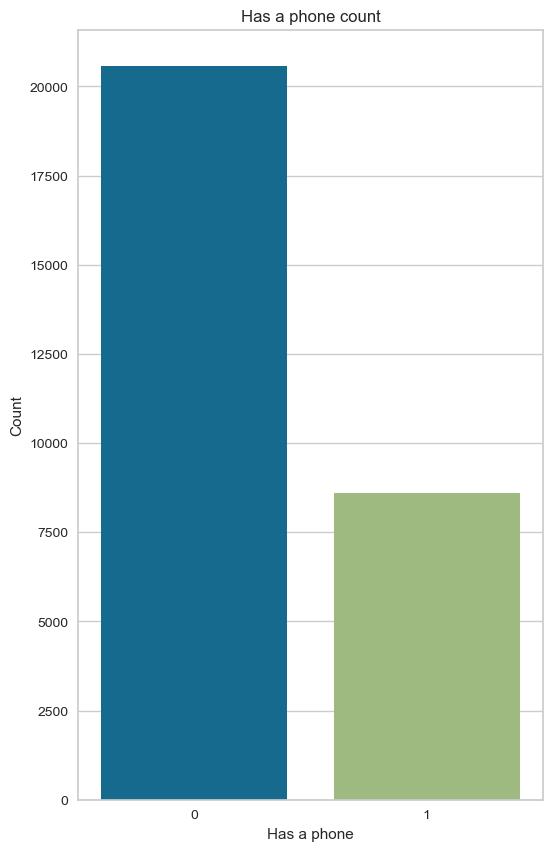

In [81]:
create_bar_plot(cc_train_copy,'Has a phone')

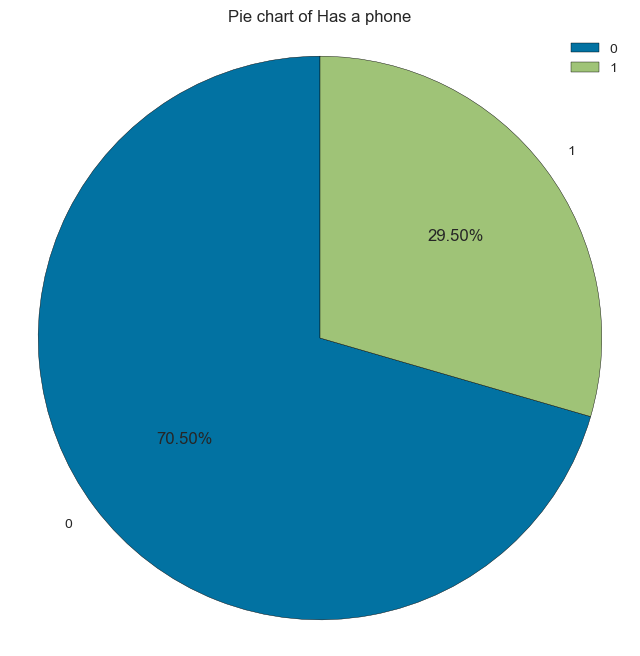

In [82]:
create_pie_plot(cc_train_copy,'Has a phone')

### Has an email
Interestingly, more than 90 % of applicants don’t have an email

Note: Here, 0 is no and 1 is yes

In [83]:
gen_info_feat(cc_train_copy,'Has an email')

Description:
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
Has an email                      
0             26532          90.97
1              2633           9.03


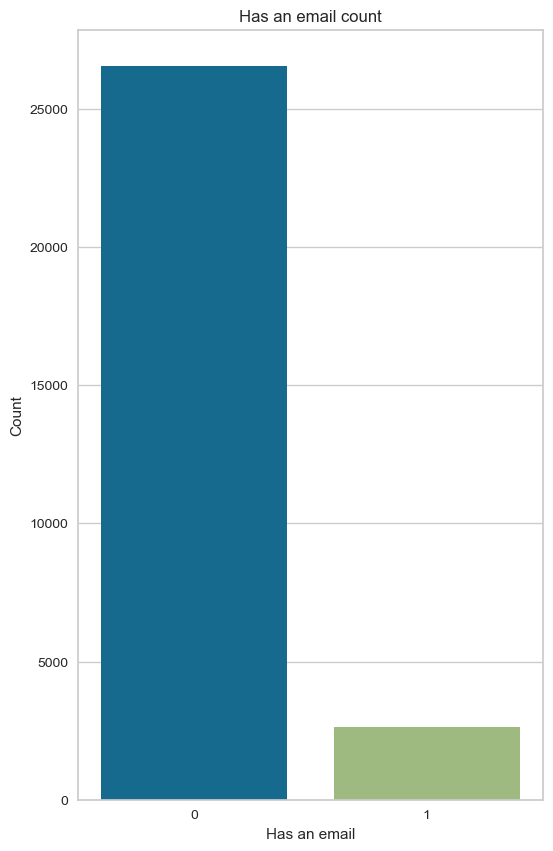

In [84]:
create_bar_plot(cc_train_copy,'Has an email')

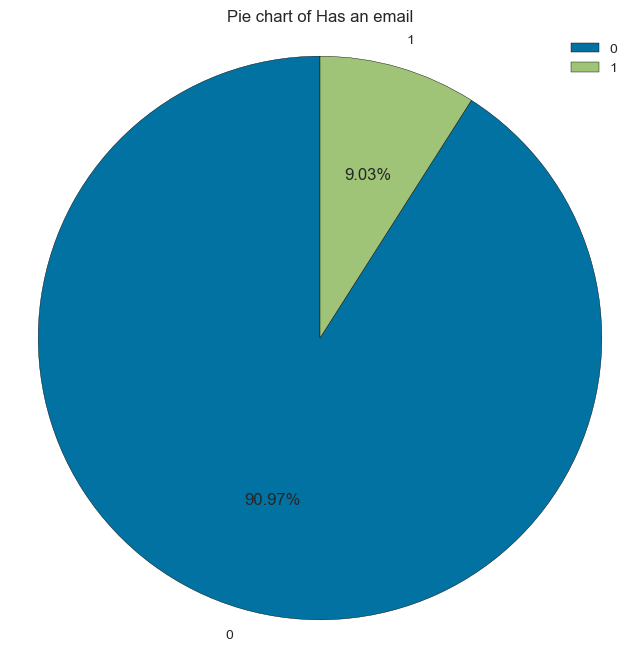

In [85]:
create_pie_plot(cc_train_copy,'Has an email')

### Account age
Most accounts are 26 months old. The account age feature is not normally distributed; it is positively skewed. Another observation is that, on average, bad clients’ accounts are 34 months old vs 26 months old for good clients’ accounts.

In [86]:
gen_info_feat(cc_train_copy,'Account age')

Description:
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
**************************************************
Object type:float64


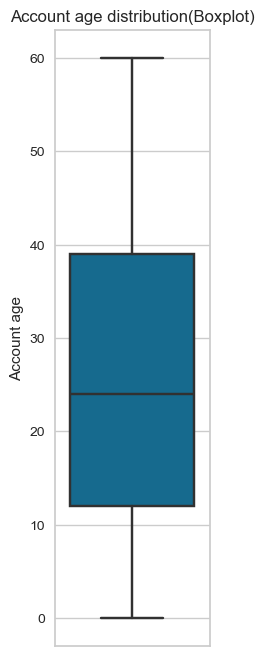

In [87]:
create_box_plot(cc_train_copy,'Account age')

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


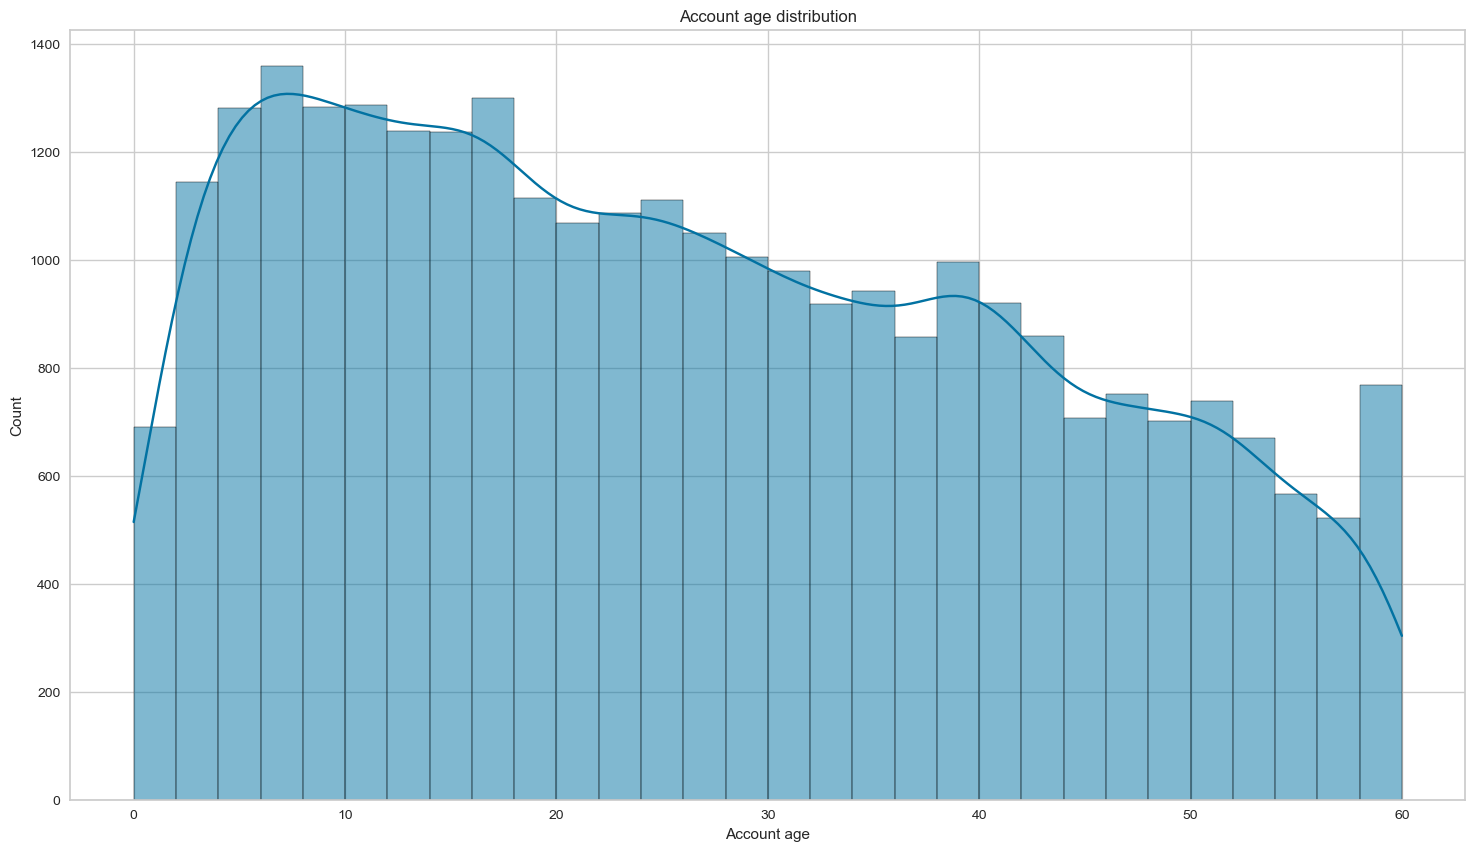

In [88]:
create_hist_plot(cc_train_copy,'Account age', the_bins=30)

bivariate analysis with target variable

Is high risk
0   26.00
1   34.04
Name: Account age, dtype: float64


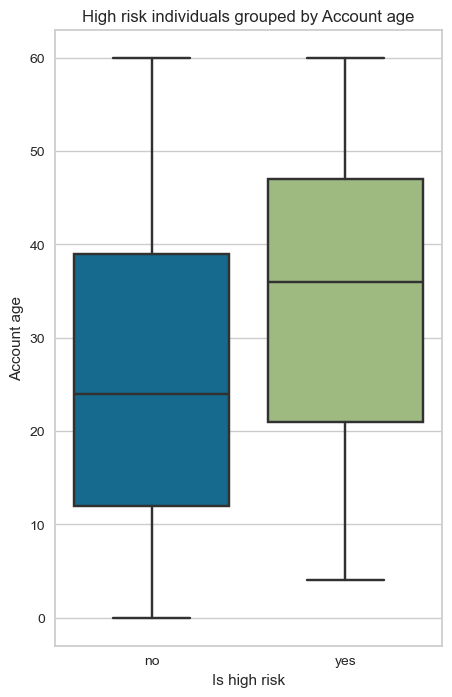

In [89]:
low_high_risk_box_plot(cc_train_copy,'Account age')

### Is high risk (target variable)
Most applicants are good clients (98% of applicants). I have imbalanced data that needs to be balanced using SMOTE before training on a model.

When we refer to imbalanced data, we're describing a situation where the classes or categories in the dataset are not represented equally. Instead, one class may significantly outnumber the others, leading to an imbalance in the distribution of classes.

Note: Here, 0 is no and 1 is yes

In [90]:
gen_info_feat(cc_train_copy,'Is high risk')

Description:
count   29165.00
mean        0.02
std         0.13
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Is high risk, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
Is high risk                      
0             28666          98.29
1               499           1.71


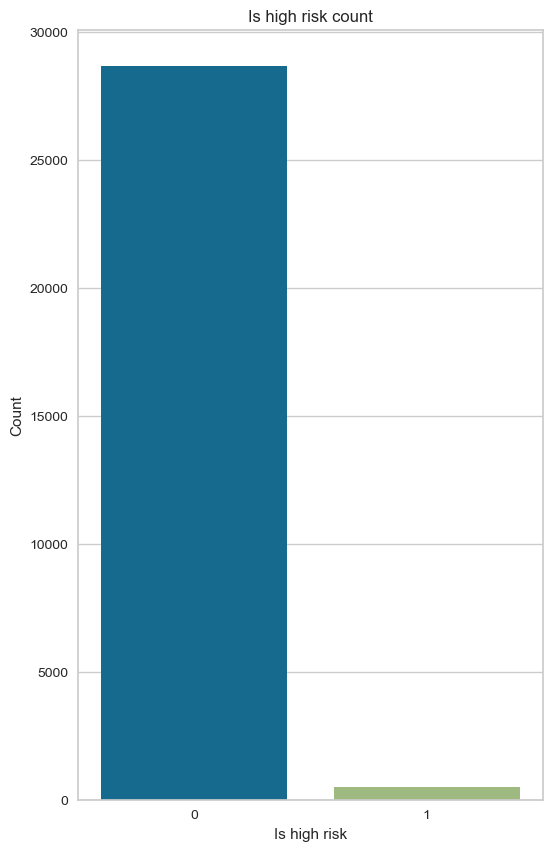

In [91]:
create_bar_plot(cc_train_copy,'Is high risk')

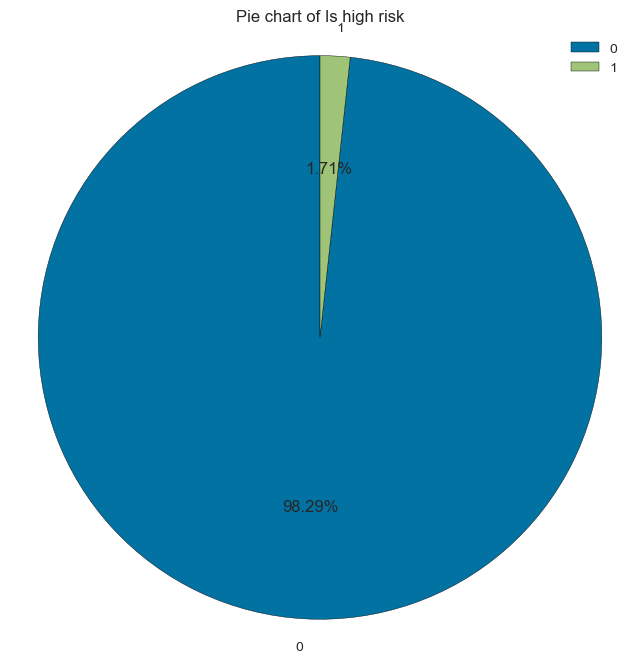

In [92]:
create_pie_plot(cc_train_copy,'Is high risk')

### Bivariate analysis

Looking at the pairplot (scatter plots of pairwise relationships in a dataset), I can see a positive linear correlation between the family member and the children’s count. It makes sense; the more children someone has, the larger the family member count. It is a multicollinearity problem (two highly correlated features) which is not ideal for training a model. We will need to drop one of them.

Another trend is the Employment length and age. It also makes sense; the longer the employment length, the older someone is.

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

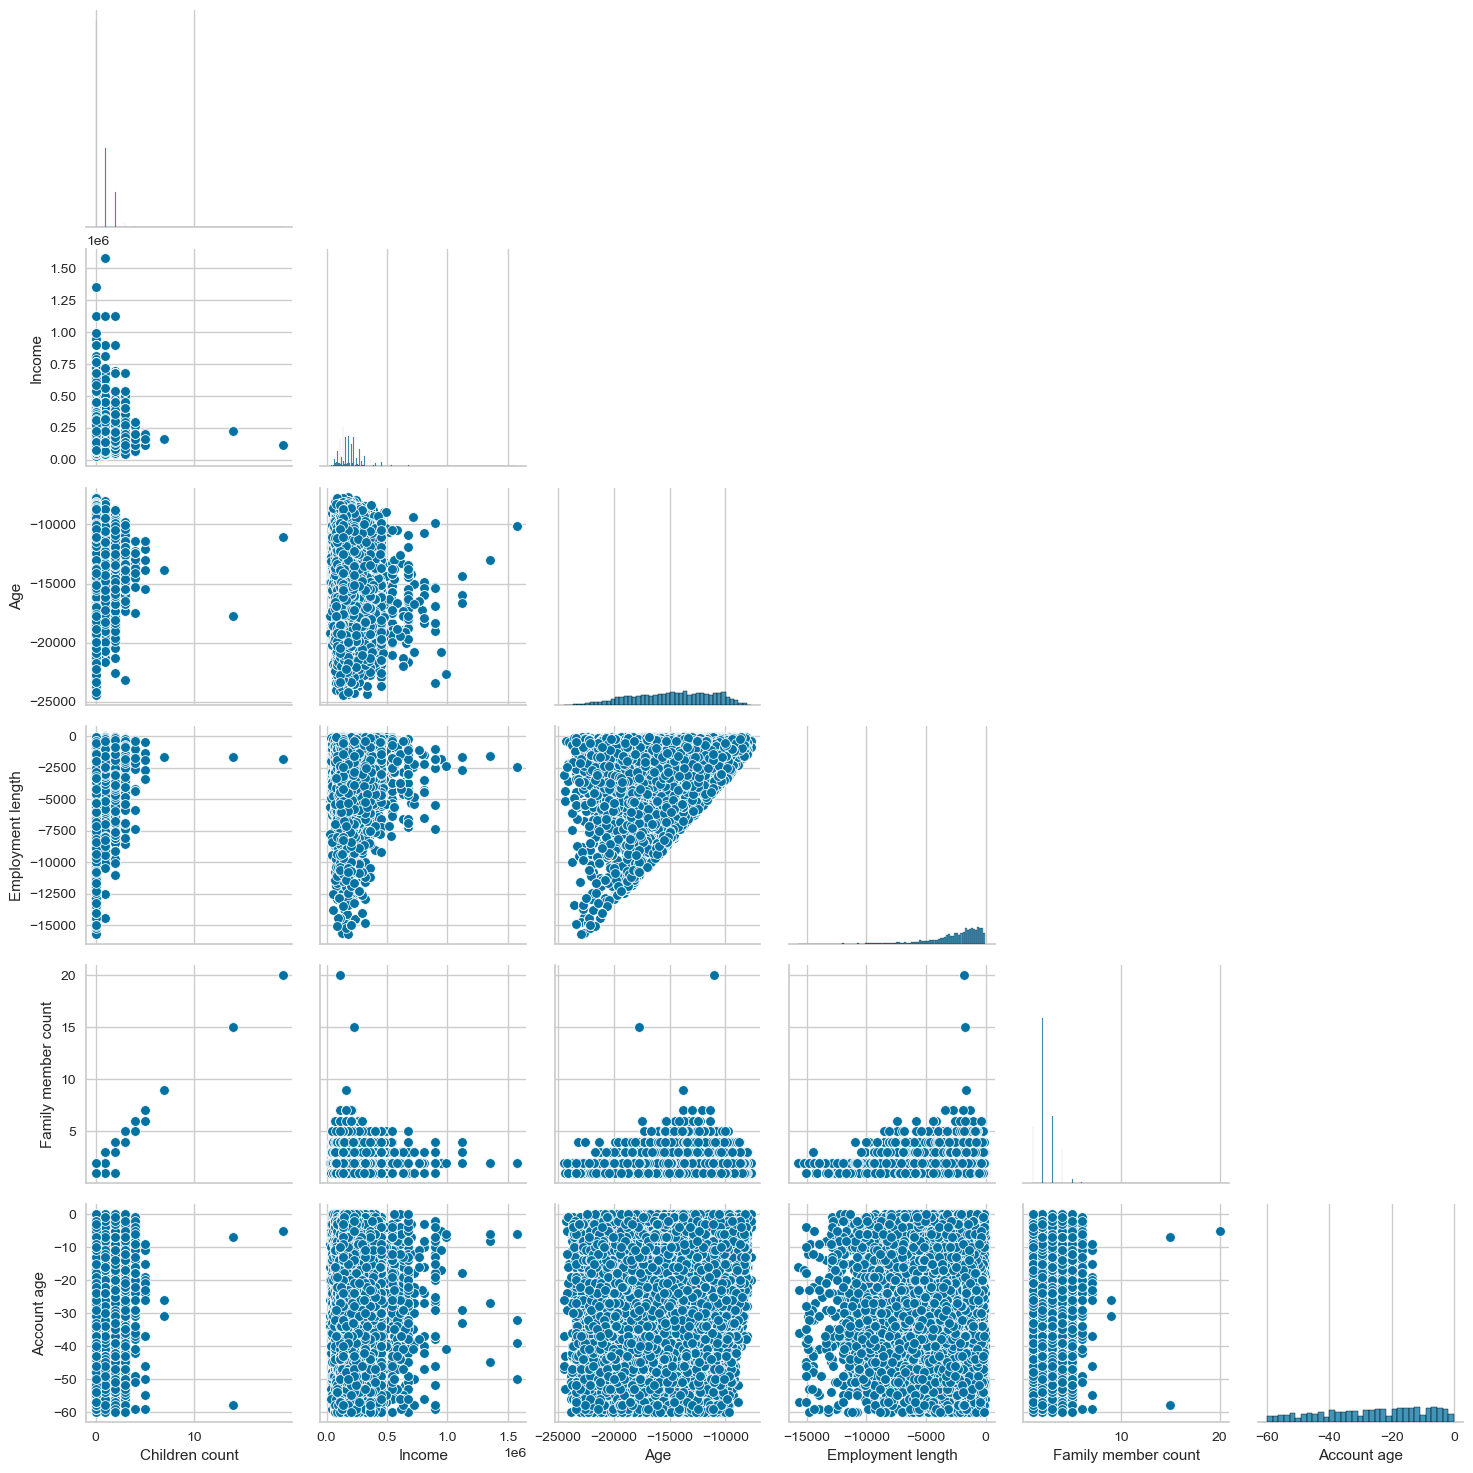

In [93]:
cc_train_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

I will start with the family member count vs children count. Of course, the more children a person has, the larger the family count. We added a line of best fit, also called the regression line

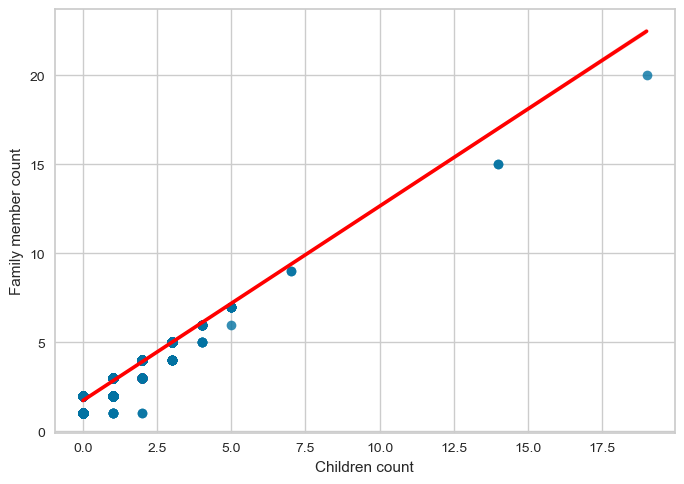

In [94]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

When i compare the employment length and age, the scatterplot shows a trend between the age and the length of employment.

It is shaped like a reversed triangle because the applicants’ age increases with the employment length. You can’t have an employment length that is superior to the age.

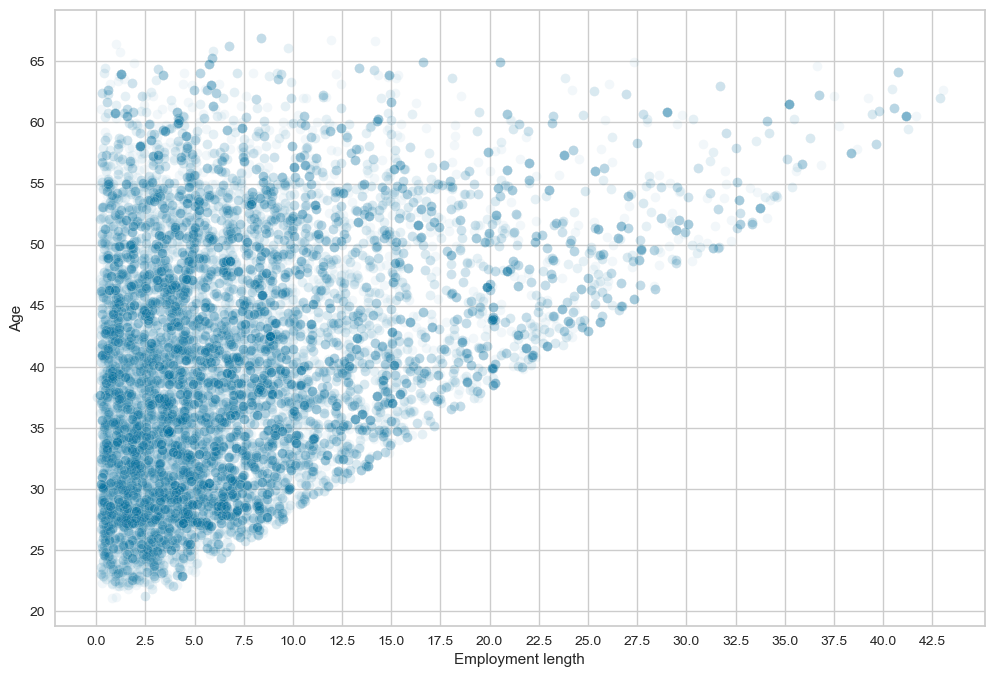

In [95]:
y_age = np.abs(cc_train_copy['Age'])/365.25
x_employ_length=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x=x_employ_length, y=y_age, alpha=0.05)  # Pass x and y as keyword arguments
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()


Now comparing account age and applicant age, i can see that most applicants are between 20 and 45 years old and have an account less than 25 months old. This information is deduced from darker blue hexagons (high-density area) between 22 and 43 on the Y axis and between 3 and 28 on the X axis.

In [96]:
cc_train_copy.head(3)

ID Gender Has a car Has a property  Children count    Income  \
0  5037048      M         Y              Y               0 135000.00   
1  5044630      F         Y              N               1 135000.00   
2  5079079      F         N              Y               2 180000.00   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate               Higher education  Single / not married   
2  Commercial associate  Secondary / secondary special               Married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0       With parents -16271              -3111                   1   
1  House / apartment -10130              -1651                   1   
2  House / apartment -12821              -5657                   1   

   Has a work phone  Has a phone  Has an email    Job title  \
0                 0            0             0   Core staff   
1                 0            0             0  Accountants   
2                 0            0             0     Laborers   

   Family member count  Account age  Is high risk  
0                 2.00       -17.00             0  
1                 2.00        -1.00             0  
2                 4.00       -38.00             0

C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


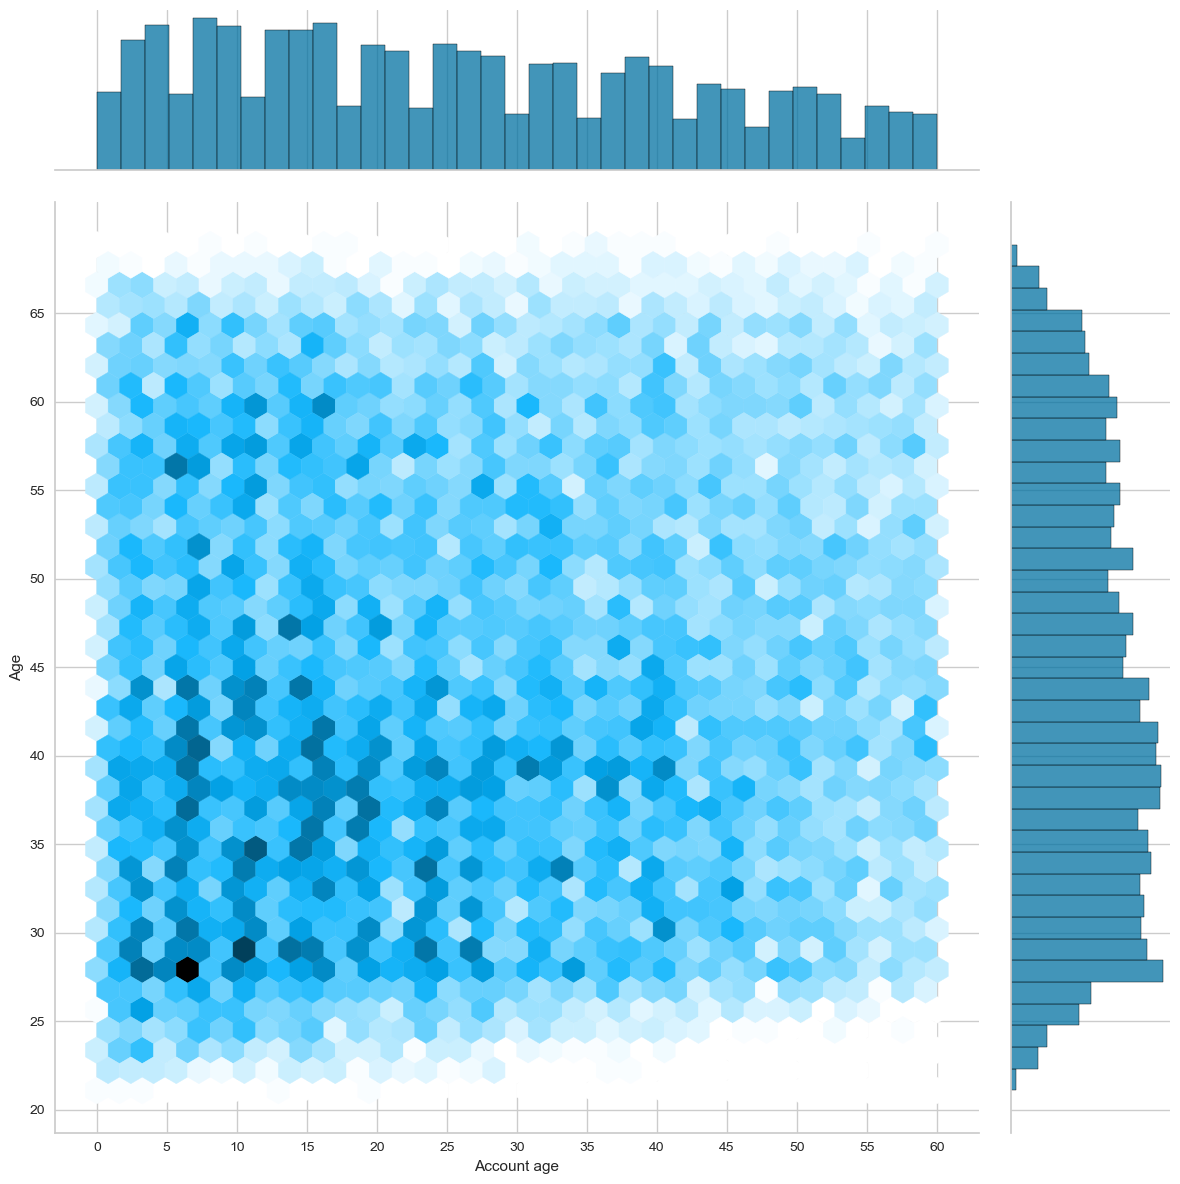

In [97]:
y_age = np.abs(cc_train_copy['Age']) / 365.25
x_Account_age = np.abs(cc_train_copy['Account age'])
sns.jointplot(x=x_Account_age, y=y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

### Heatmap

Time to do a correlation between all the numerical features using a heatmap. This heatmap shows the correlation between all the numerical features; the darker the cell, the more correlated the two features are, and the lighter the color, the less correlated the two features.

No feature is correlated with the target feature (Which is high risk). I can see a strong correlation (0.89) between family member count and children count, as previously seen with the pairplot (The more children a person has, the larger the family count). Age has some positive correlation (0.30) with the family member count and children count. The older a person is, the most likely they will have a larger family and consequently more children.

Another positive correlation (0.31) is having a phone and having a work phone. I have a slightly positive correlation between age and work phone(0.18); younger people will be less likely to own a work phone. As previously discussed, we also have a negative (-0.62) between employment length and age.

In [98]:
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')

In [99]:
print(is_high_risk_int.dtype)

int32


In [100]:
print(cc_train_copy['Is high risk'].unique())

[0 1]


C:\Users\baiji\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


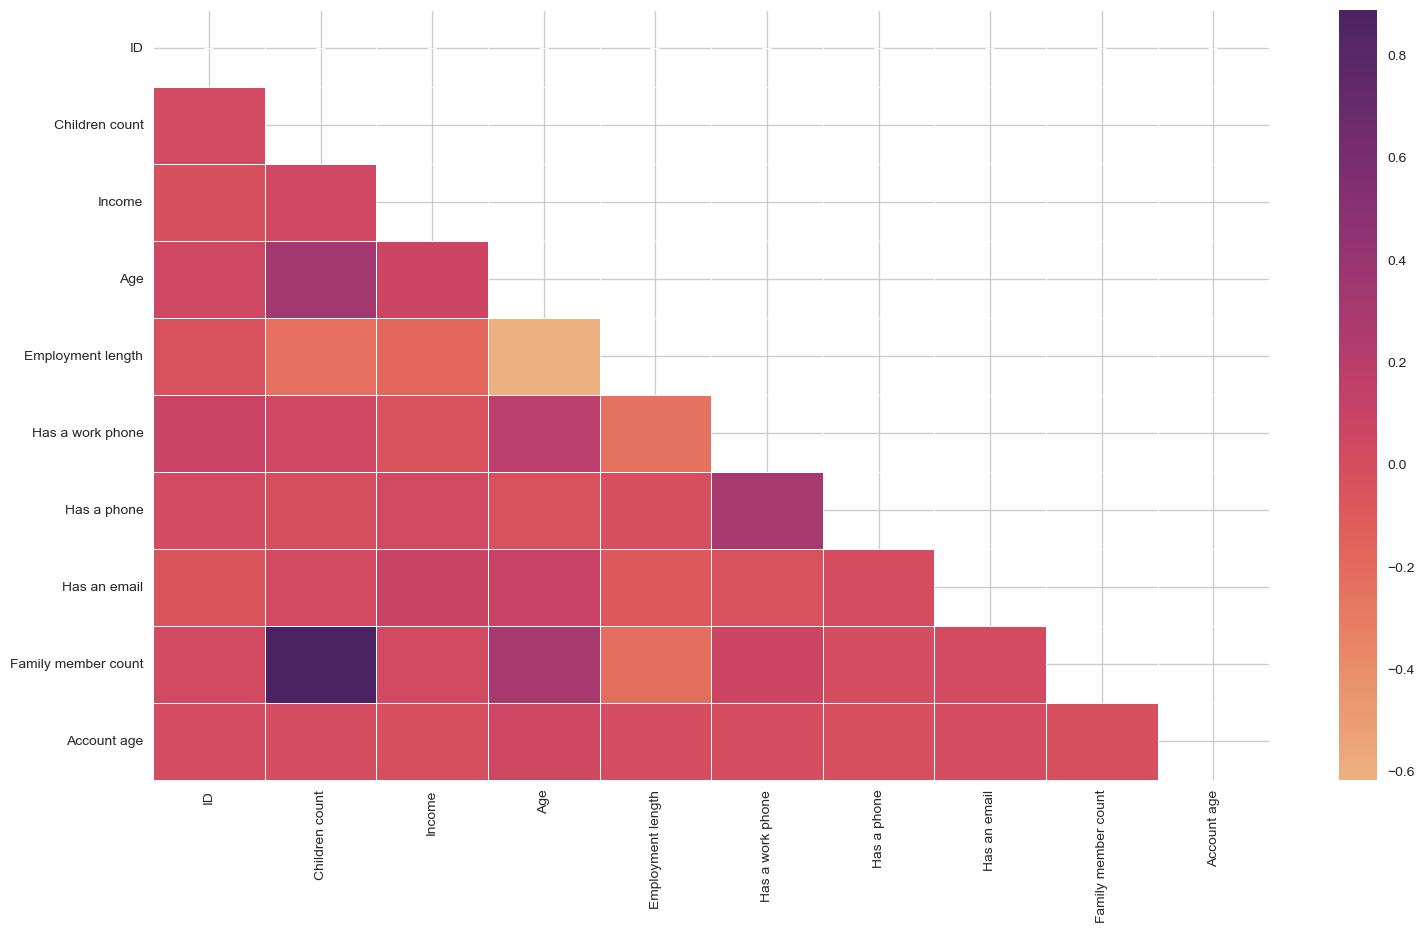

In [101]:
numeric_columns = cc_train_copy.select_dtypes(include=['number'])
numeric_columns = numeric_columns.drop(['Has a mobile phone', 'Is high risk'], axis=1)
cc_train_copy_corr_no_mobile = numeric_columns.corr()
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare', mask=mask, linewidths=0.5)
plt.show()



### ANOVA

ANOVA (analysis of variance) between age and other categorical features.

ANOVA tells if there are any statistical differences between the means of two or more independent features (categorical features).

I am use box plots to compare age’s mean and different categorical features. Female applicants are older than their male counterparts, and those who don’t own a car with property owners tend to be older. Of course, the pensioners are older than those working (I also see that some have pensioned at a young age, those are outliers).

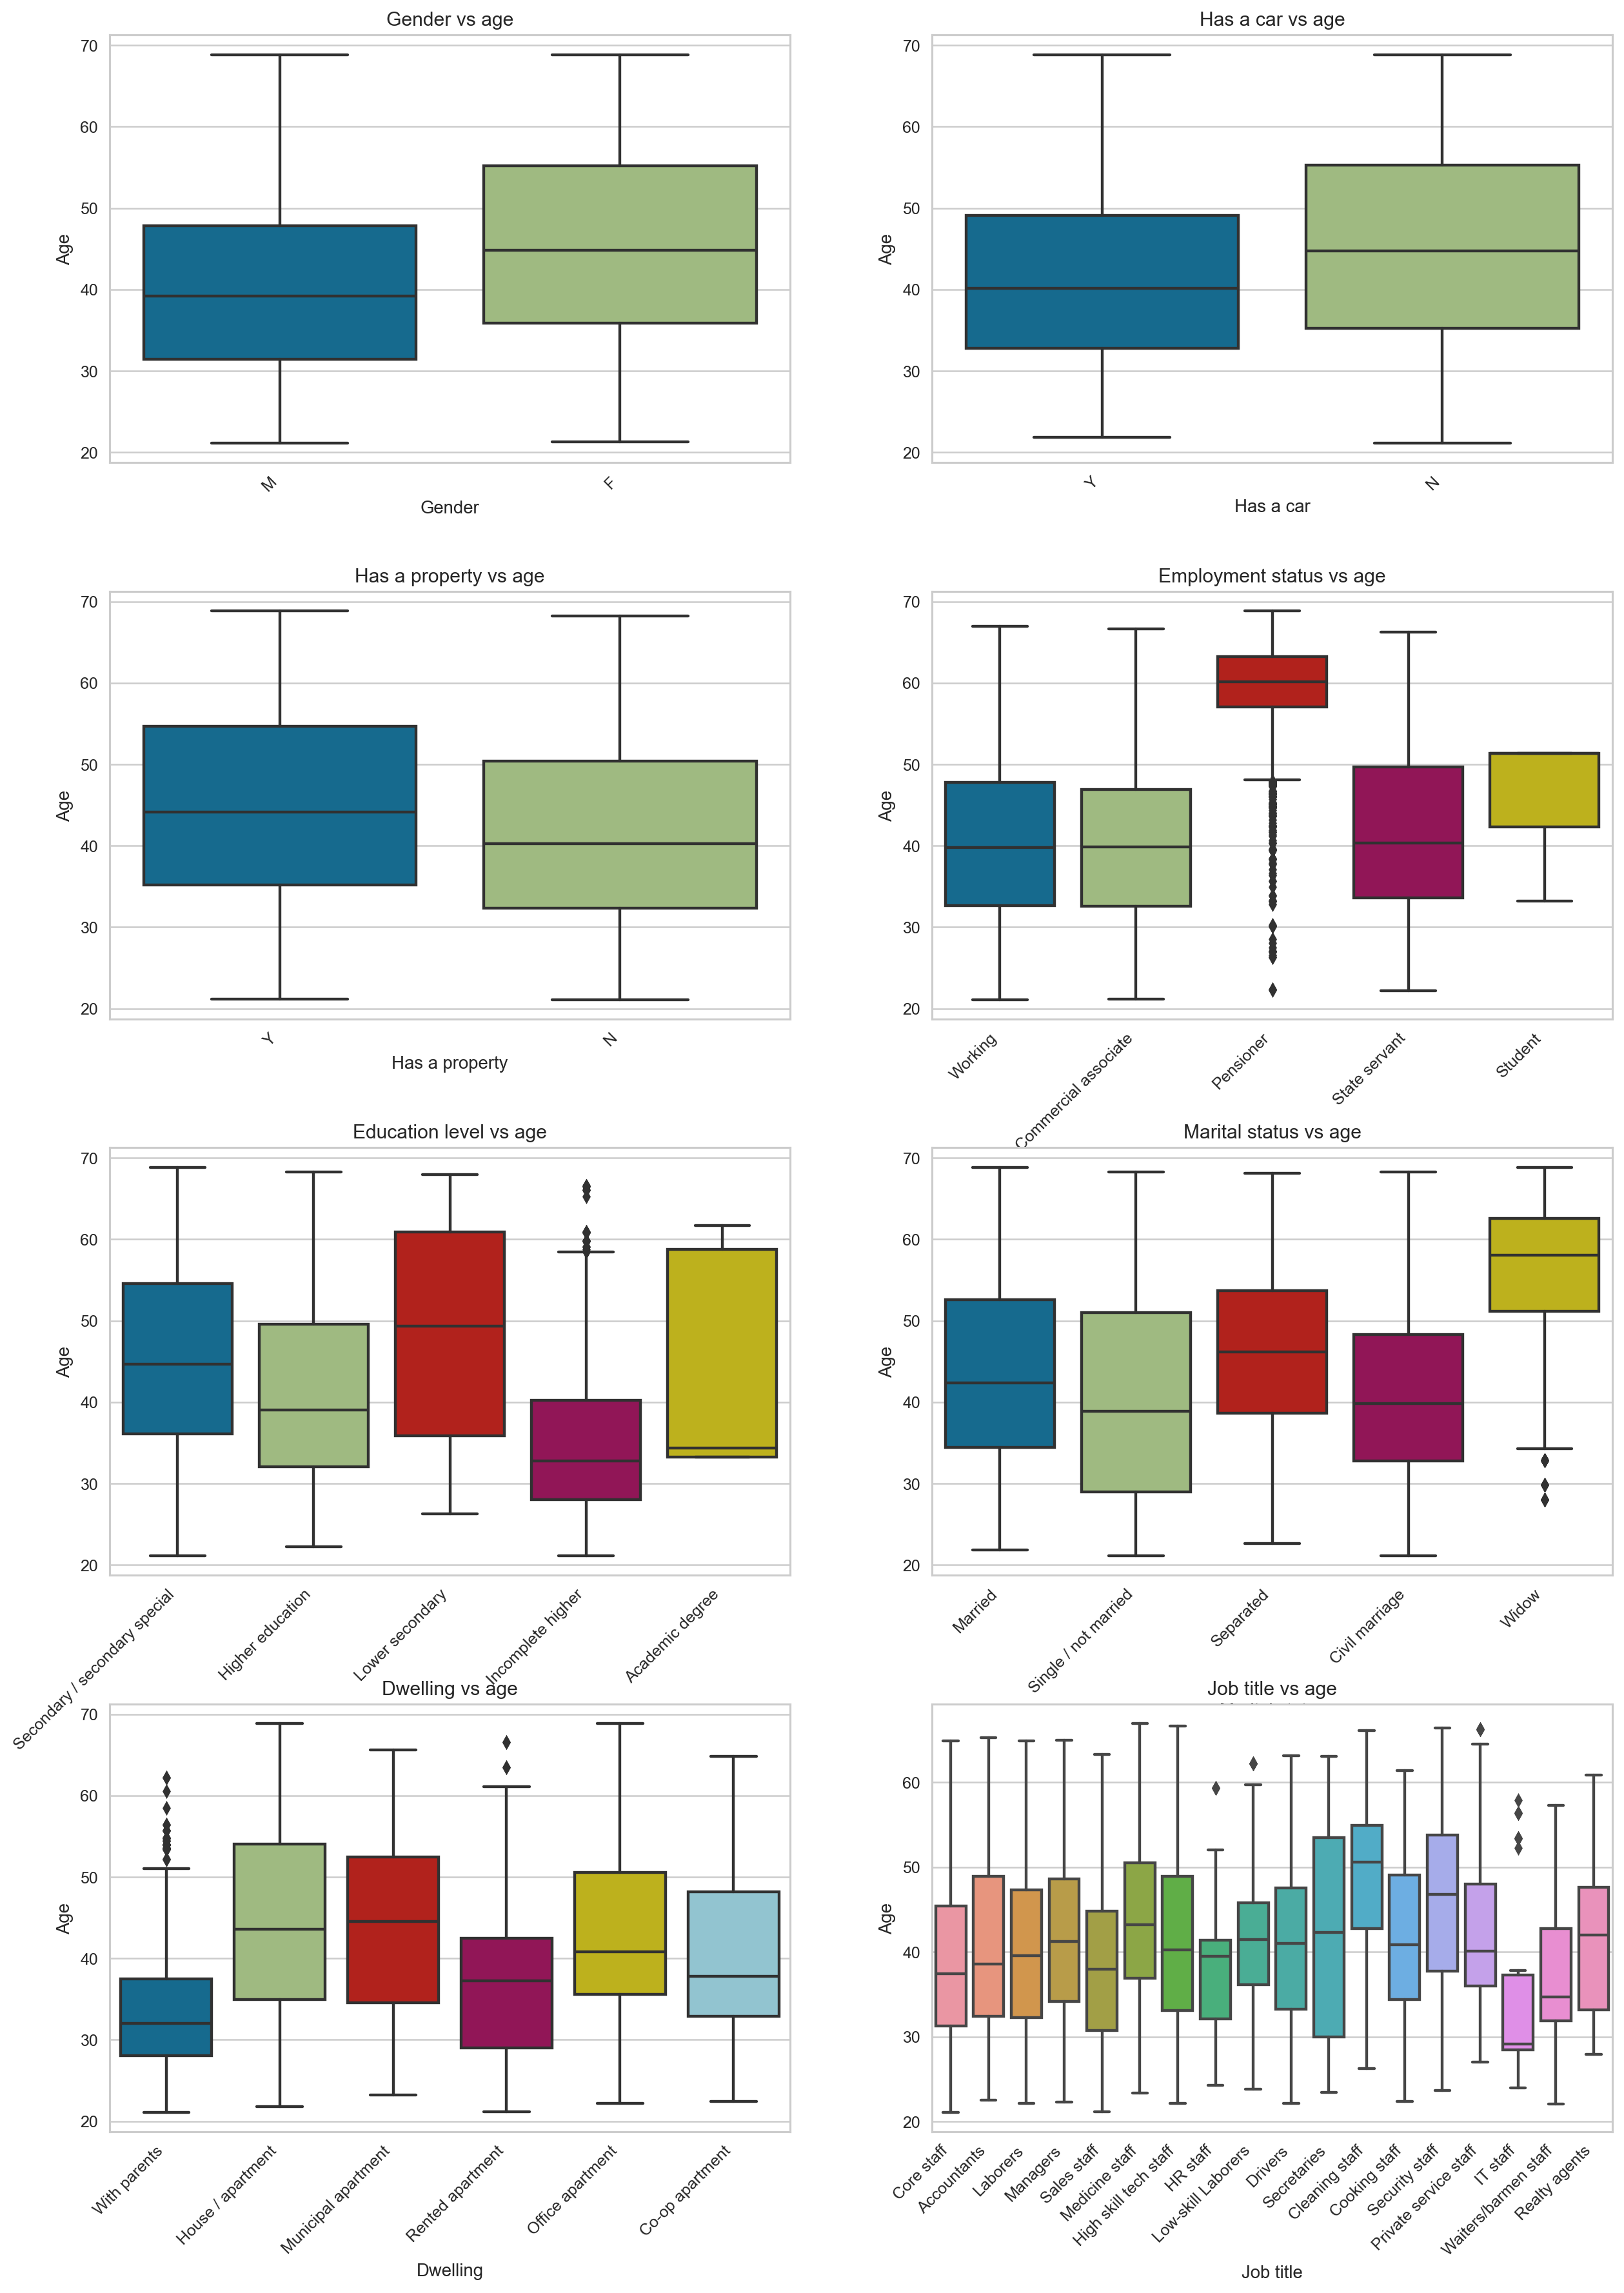

In [102]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

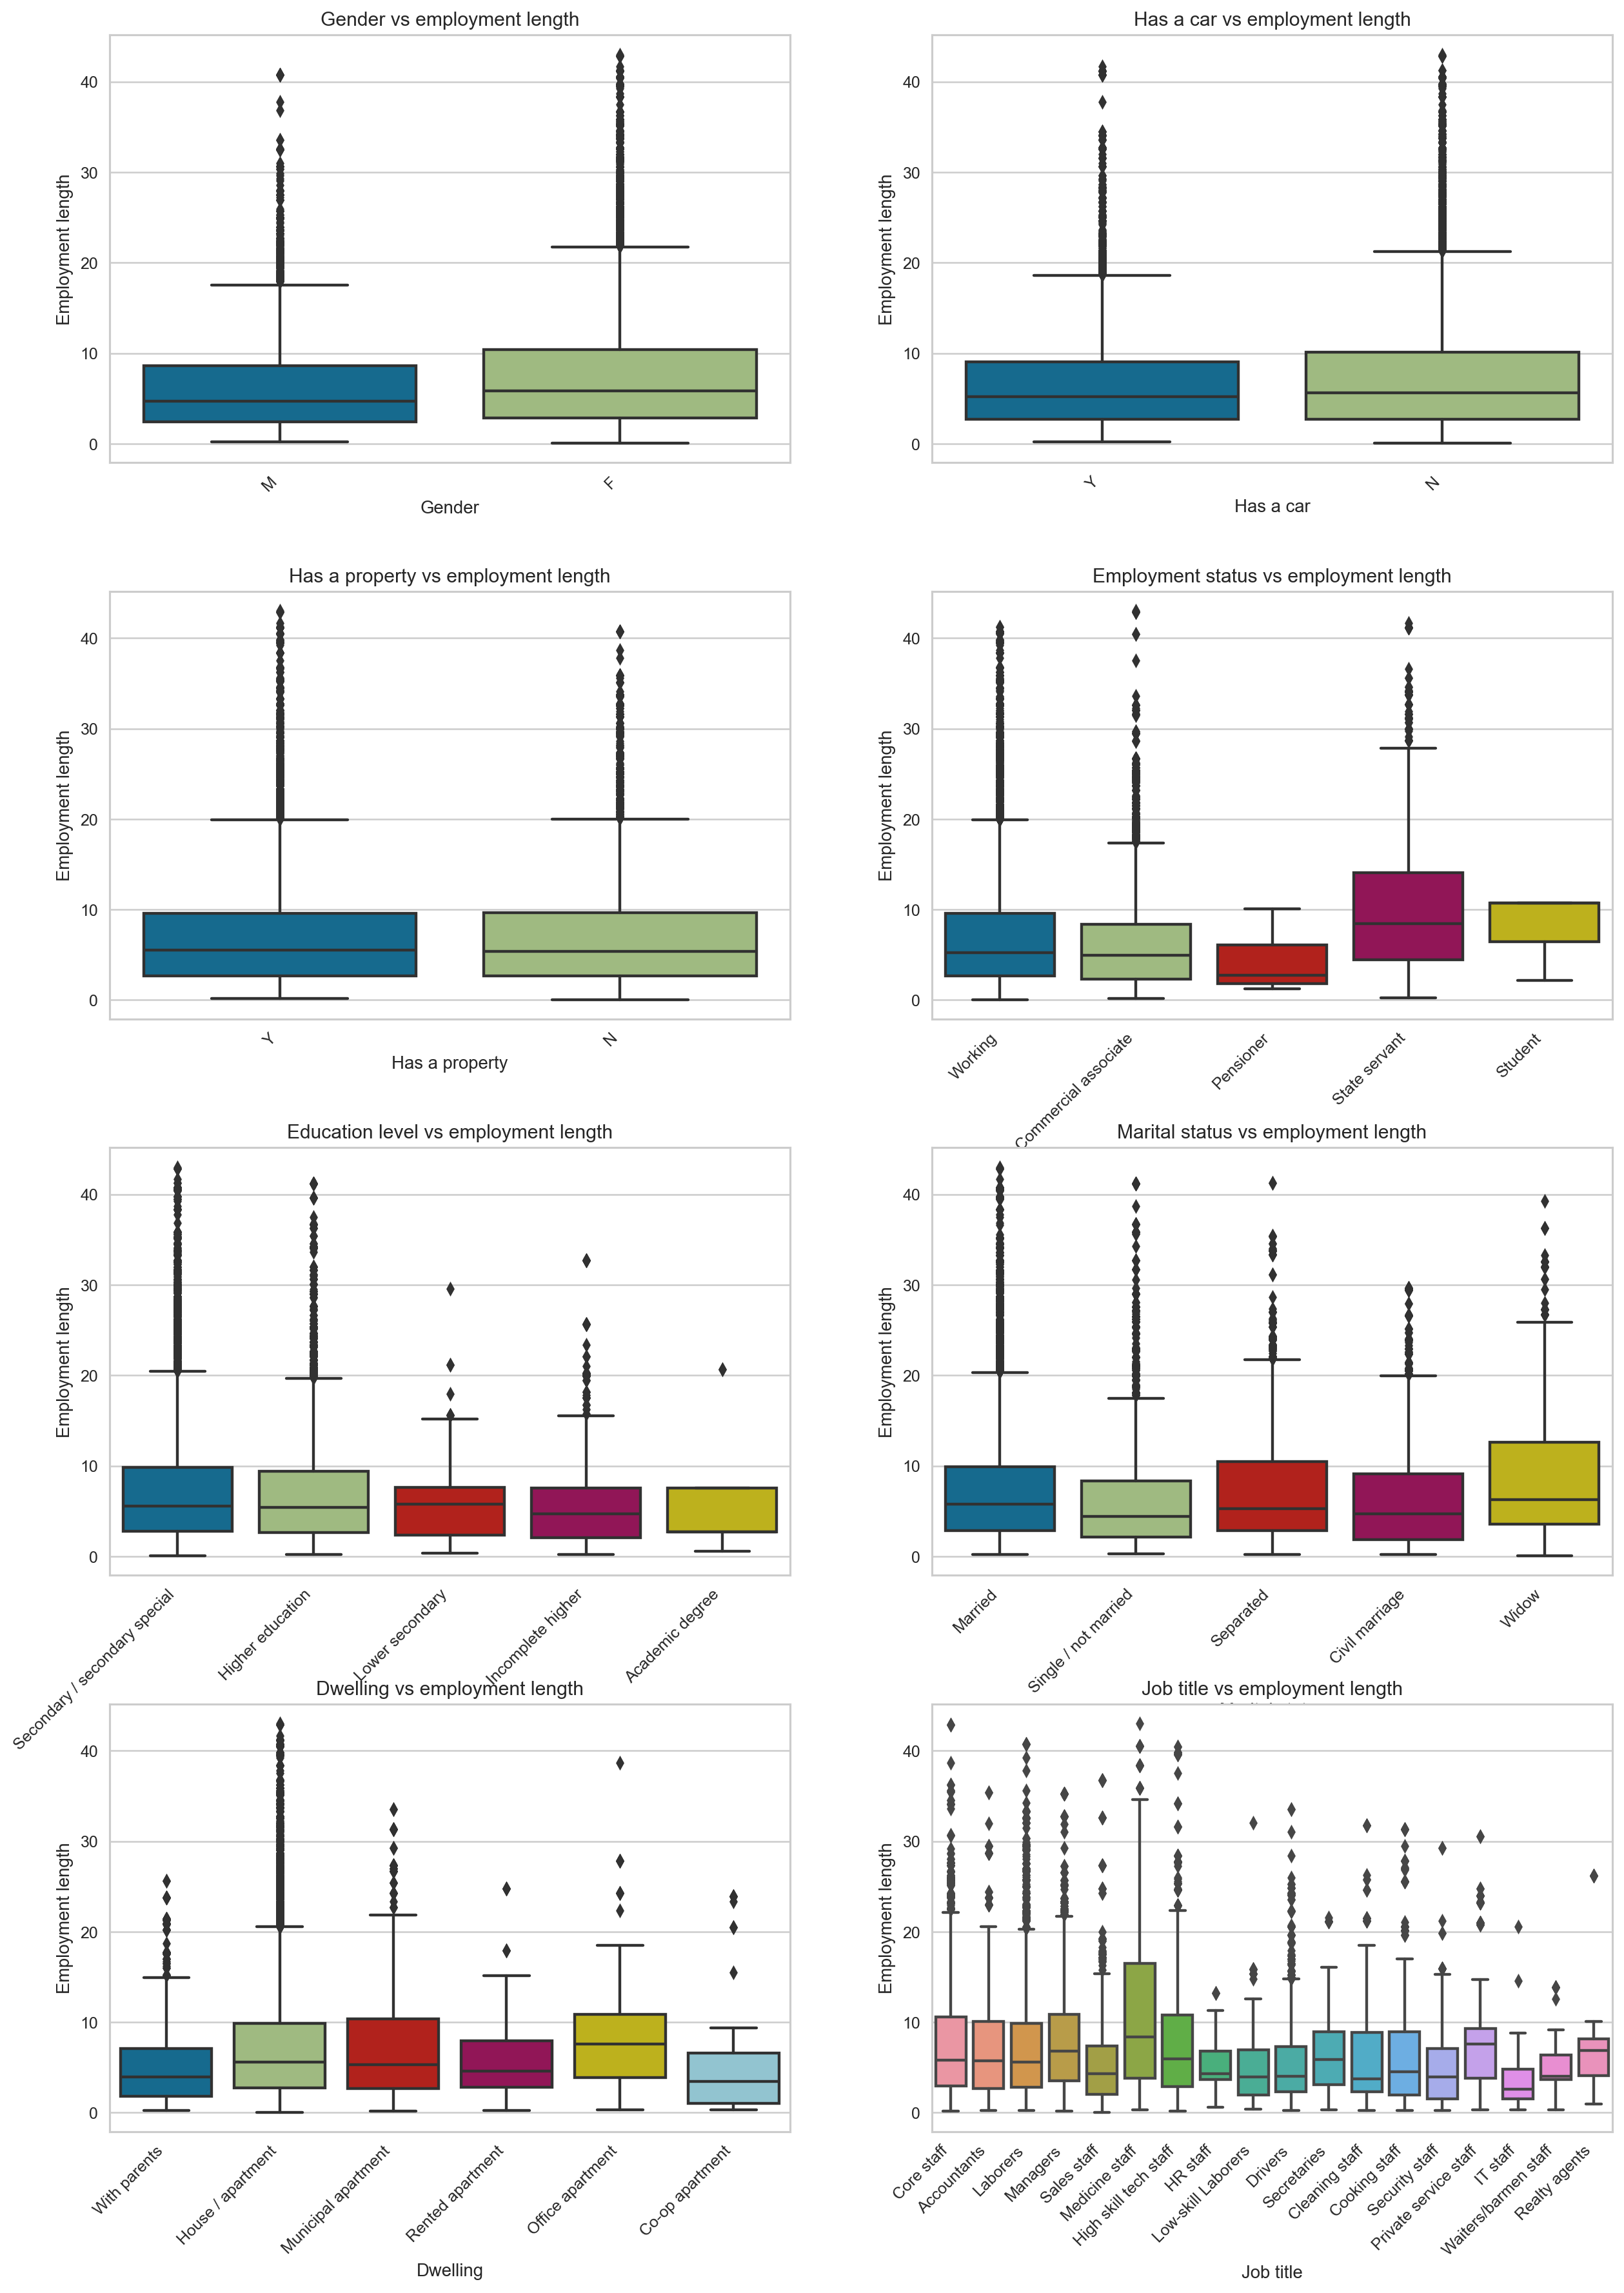

In [103]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### Practical data training
### Prepare the data

Here is a list of all the transformations that need to be done on each feature:

ID:

 - Drop the feature

Gender:

 - One hot encoding

Age:

 - Min-max scaling
 - Fix skewness
 - Absolute values and divide by 365.25

Marital status:

  - One hot encoding

- Family member count

    - Fix outliers

- Children count

    - Fix outliers
    - Drop feature

- Dwelling type

    - One hot encoding

- Income

    - Remove outliers
    - Fix skewness
    - Min-max scaling

- Job title

    - One hot encoding
    - Impute missing values

Employment status:

 - One hot encoding

Education level:

 - Ordinal encoding

Employment length:

 - Remove outliers
 - Min-max scaling
 - Absolute values and divide by 365.25
 - change days of employment of retirees to 0

Has a car:

 - Change it to numerical
 - One-hot encoding

Has a property:

 - Change it to numerical
 - One-hot encoding

Has a mobile phone:

 - Drop feature

Has a work phone:

 - One-hot encoding

Has a phone:

 - One-hot encoding

Has an email:

 - One-hot encoding

Account age:

 - Drop feature

Is high risk(Target):

 - Change the data type to numerical
 - balance the data with SMOTE
TE

### Data Cleaning

Here we are creating a class to handle outliers. But why do i have to remove the outliers?

Outliers are data points that differ significantly from other observations in the dataset. Outliers can spoil and mislead the training process resulting in longer training times, less accurate models and ultimately poorer results, which means that outliers must remove from the dataset.

This class will remove outliers more or less than 3 inter-quantile ranges away from the mean. This class will be the first class in the scikit-learn Pipeline to c
my our cai, we use 3 IQR, which is more sensitive to extreme outliers than 1.5 IQR.all.

In [104]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            Q1 = df[self.feat_with_outliers].quantile(.25)
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Feature selection

Next is feature selection; here, i will drop the features that i judge are not useful in our prediction. Note this is not a feature selection based on the model coefficients or feature importance; it is purely based on logic.

The features to be dropped are ID, has a mobile phone, children count, job title, account age.

In [105]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Feature engineering

This class will convert the features that use days (Employment length, Age) to absolute value because we can’t have negative days of employment.

In [106]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

The following class will convert the employment length of retirees (set to 365243) to 0 so that it is not considered an outlier.

In [107]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

Using the cubic root transformation, this class will reduce income and age distribution skewness. Skewed features negatively affect our predictive model’s performance, and machine learning models perform better with normally distributed data.

In [108]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class will change 1 to the character “Y” and 0 to “N,” which will be more comprehensive when we do a one-hot encoding for these features Has a work phone, Has a phone, Has an email.

In [109]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class will do one-hot encoding on the categorical features, but also this class will keep the names of the features. We want to keep the feature names instead of an array without names (default) because the feature names will be used for feature importance.

In [110]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

This class will convert the education level to an ordinal encoding. Here we use ordinal encoding instead of one-hot encoding because we know that the education level is ranked (University is higher than primary school).

In [111]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

This class will scale the feature using min-max scaling while keeping the feature names. You may ask why we have to scale. Well, some of the numerical features range from 0 to 20 (Family member count) while others range from 27000 to 1575000 (Income), so this means that some machine learning algorithms will weight the features with big numbers more than the feature with smaller numbers which should not be the case. So scaling all the numerical feature on the same scale (0 to 1) solve this issue.

In [112]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

This class will change the data type of the target variable to numerical as it is an object data type even though it is 0 and 1’s (0 and 1’s expressed as strings)

In [113]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

This class will oversample the target variable using SMOTE because the minority class (Is high risk = 1) is scarce in the data, as we have seen while doing EDA of the target variable (1 only accounts for about 1.71% of the total data while 0 represent 98.29%).

In [114]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

### Data Preprocessing

Now i will create the data preprocessing pipeline using the built sklearn function Pipeline. This function calls each class in the pipeline sequentially, starting from the outlier remover to the oversample class. The dataset will be transformed consecutively from the first class to the next one till the end. The pipeline will be stored in a variable called pipeline and will call fit_transform on that variable, pass the dataframe i want to transform and return the result.

In [115]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

Now i pass in the training dataset.

In [116]:
pd.options.mode.chained_assignment = None
cc_train_prep = full_pipeline(cc_train_copy)

Check how many rows and columns we have after the transformation.

In [117]:
cc_train_prep.shape

(46544, 34)

In [118]:
pd.set_option('display.max_columns', None)
cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   1.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                    0.00                         0.00   
1                                    1.00                         0.00   
2                                    1.00                         0.00   
3                                    1.00                         0.00   
4                                    0.00                         0.00   

   Employment status_State servant  Employment status_Student  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                       1.00         0.00         1.00              0.00   
1                       0.00         0.00         1.00              1.00   
2                       0.00         1.00         0.00              0.00   
3                       0.00         0.00         1.00              0.00   
4                       1.00         1.00         0.00              1.00   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0              1.00                1.00                0.00           1.00   
1              0.00                1.00                0.00           1.00   
2              1.00                1.00                0.00           1.00   
3              1.00                1.00                0.00           1.00   
4              0.00                1.00                0.00           0.00   

   Has a phone_Y  Has an email_N  Has an email_Y  Income  Education level  \
0           0.00            1.00            0.00    0.42             4.00   
1     

Now, i extract the target variable Is high risk from the dataframe and create a new dataframe composed of independent features (also called predictor, aka all the features except the target variable) as X_cc_train_prep and the target variable as y_cc_train_prep.

In [119]:
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

In [120]:
X_cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   1.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                    0.00                         0.00   
1                                    1.00                         0.00   
2                                    1.00                         0.00   
3                                    1.00                         0.00   
4                                    0.00                         0.00   

   Employment status_State servant  Employment status_Student  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                       1.00         0.00         1.00              0.00   
1                       0.00         0.00         1.00              1.00   
2                       0.00         1.00         0.00              0.00   
3                       0.00         0.00         1.00              0.00   
4                       1.00         1.00         0.00              1.00   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0              1.00                1.00                0.00           1.00   
1              0.00                1.00                0.00           1.00   
2              1.00                1.00                0.00           1.00   
3              1.00                1.00                0.00           1.00   
4              0.00                1.00                0.00           0.00   

   Has a phone_Y  Has an email_N  Has an email_Y  Income  Education level  \
0           0.00            1.00            0.00    0.42             4.00   
1     

In [121]:
y_cc_train_prep.head()

0    0
1    0
2    0
3    0
4    0
Name: Is high risk, dtype: int64

### Short-list promising models

Alright! time to train our models. first i create a dictionary of models and their corresponding names. This dictionary will be used as a model and train them for single classifier.

Note:  
model_name = 'sgd'
model = SGDClassifier(random_state=42, loss='perceptron')

classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

Now i will write some of the functions used for our training model. The first function is a function to plot the feature importance of the model. The feature importance is ranking features that contribute more(or less) than other features to the model prediction. The feature importance varies from one model to another.

In [122]:
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

On the other hand, this function is used to get the y predictions of the model using cross-validation prediction with k fold equal to 10.

In [123]:
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

This function will plot the confusion matrix for each of the algorithms.

In [124]:
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        plt.grid(visible=None)
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        print('\n')

The following function will plot the ROC curve of each model.

In [125]:
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        plt.grid(visible=None)
        plt.show()
        print('\n')

This other function will print the classification report. A classification report is a table that describes the performance of a classification model and has information like precision, recall, f1-score, support, accuracy.

In [126]:
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

This function will train the models and save them in the saved_models and saved_models_final folders.

In [127]:
def train_model(model,model_name,final_model=False):
    if final_model == False:
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            return model_trn
        else:
            model_trn = joblib.load(model_file_path)
            return model_trn
    else:
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            return model_trn
        else:
            model_trn = joblib.load(final_model_file_path)
            return model_trn

This function below will look at the folder_check_model which will check if saved_models folder exists; if not, it will create it.

In [128]:
def folder_check_model():
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.58      0.61      0.59     23272
           1       0.59      0.55      0.57     23272

    accuracy                           0.58     46544
   macro avg       0.58      0.58      0.58     46544
weighted avg       0.58      0.58      0.58     46544



C:\Users\baiji\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\baiji\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\baiji\anaconda3\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator CalibratedClassifierCV from version 1.3.0 when using version 1.3.2. This might lead

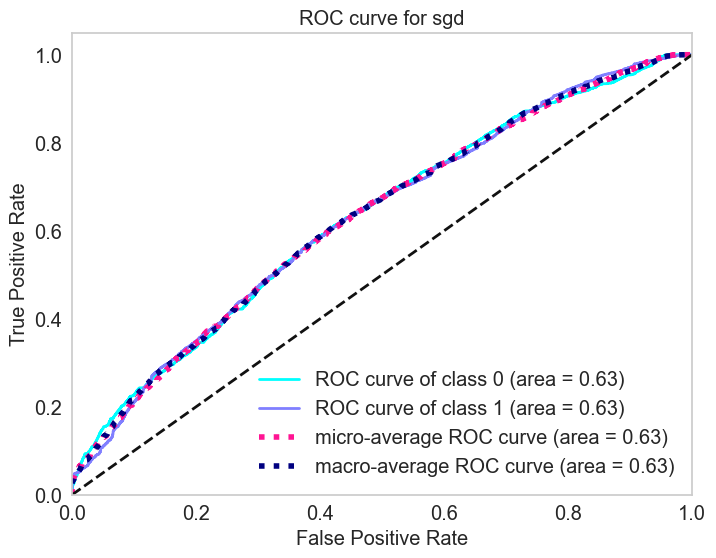

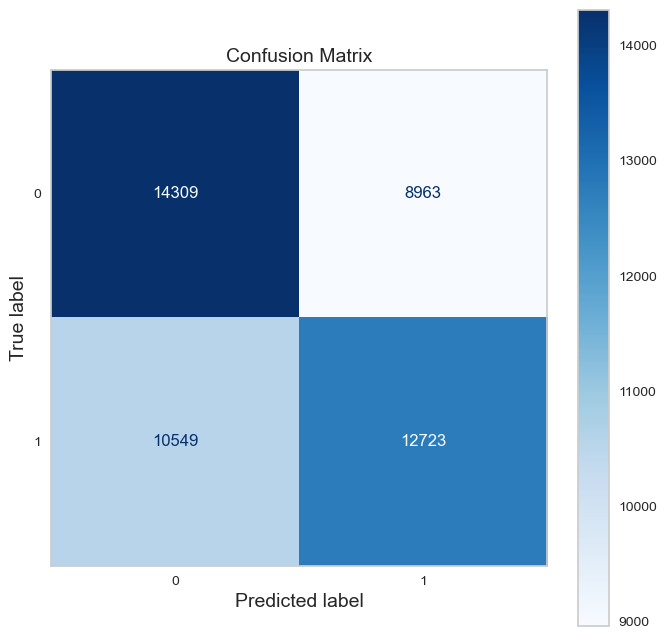



No feature importance for sgd




In [129]:
model_name = 'sgd'
model = SGDClassifier(random_state=42, loss='perceptron')
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.60      0.57      0.58     23272
           1       0.59      0.62      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



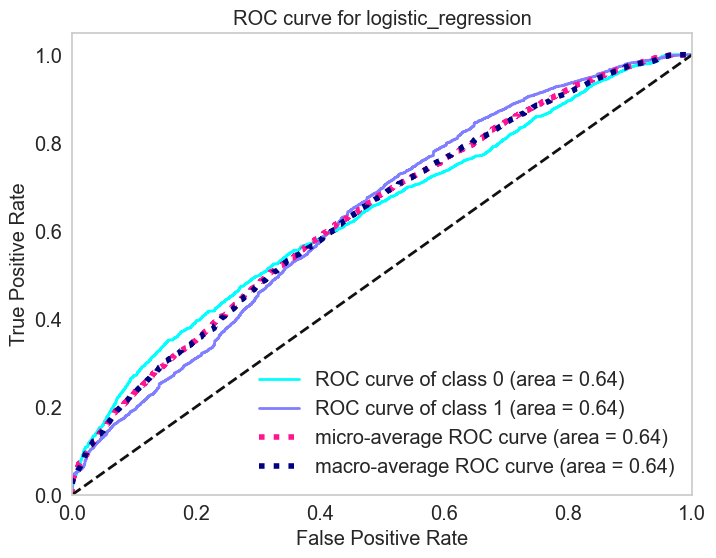

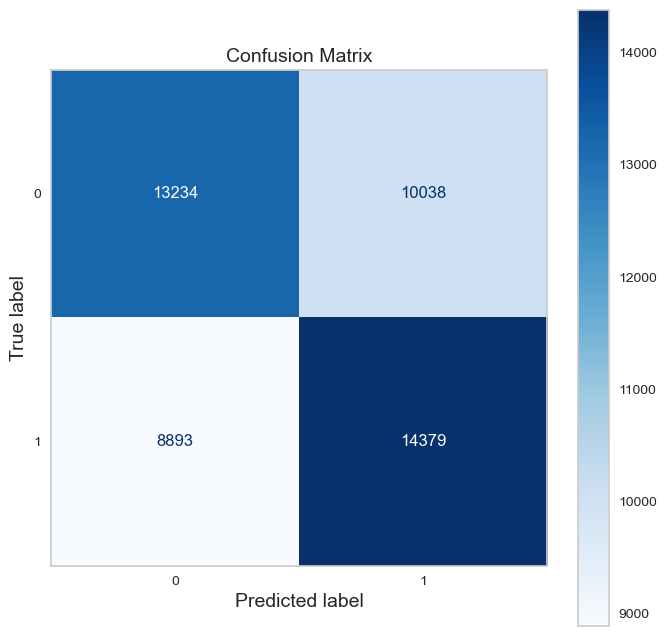

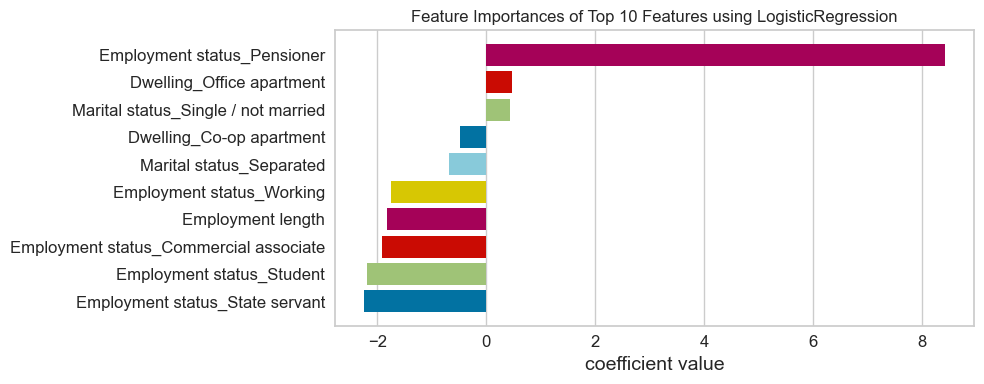

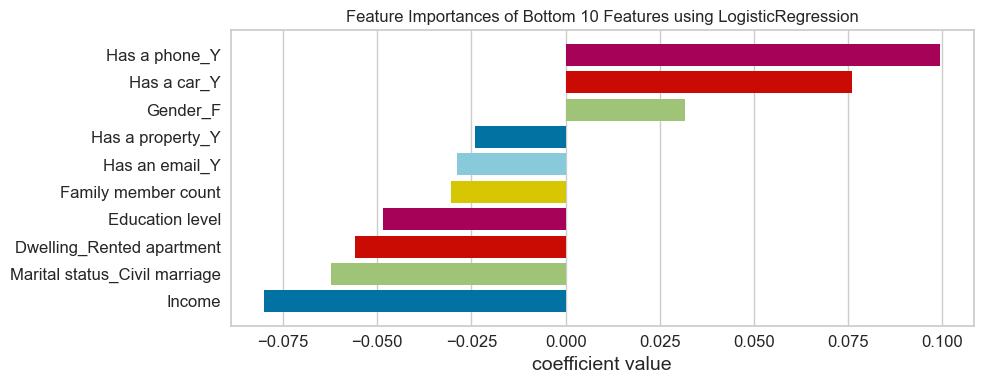

In [130]:
model_name = 'logistic_regression'
model = LogisticRegression(random_state=42,max_iter=1000)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  support_vector_machine  ----------------------


              precision    recall  f1-score   support

           0       0.87      0.82      0.84     23272
           1       0.83      0.88      0.85     23272

    accuracy                           0.85     46544
   macro avg       0.85      0.85      0.85     46544
weighted avg       0.85      0.85      0.85     46544



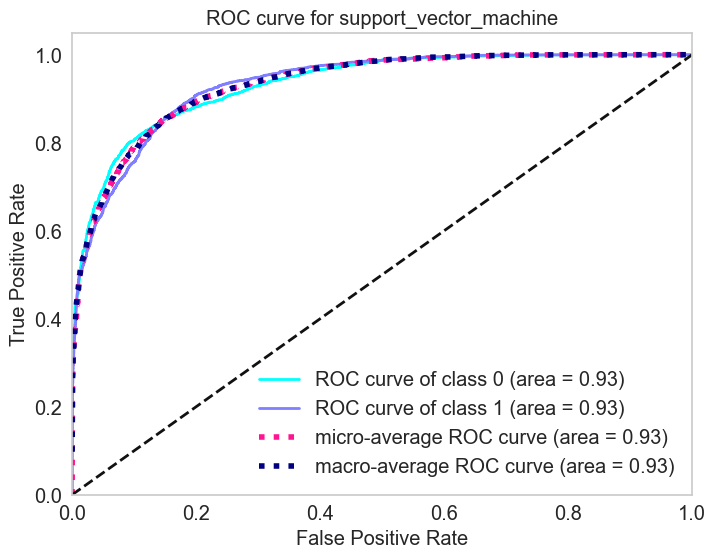

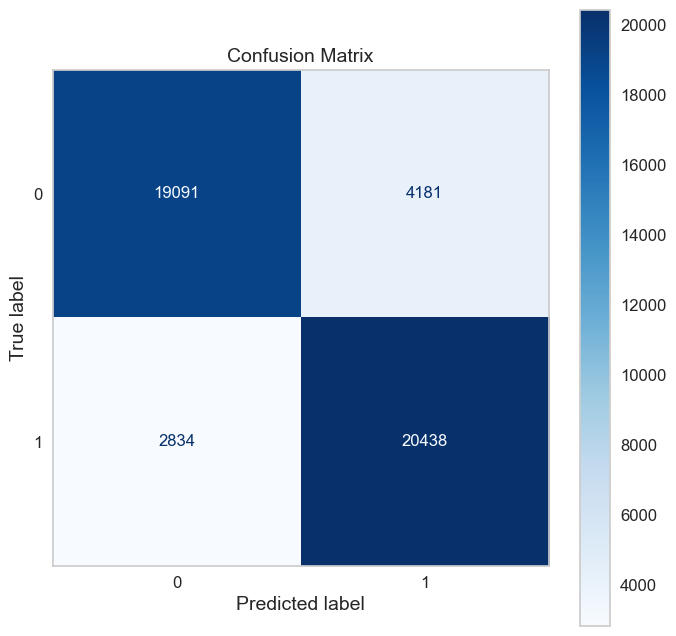



No feature importance for support_vector_machine




In [131]:
model_name = 'support_vector_machine'
model = SVC(random_state=42,probability=True)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     23272
           1       0.98      0.98      0.98     23272

    accuracy                           0.98     46544
   macro avg       0.98      0.98      0.98     46544
weighted avg       0.98      0.98      0.98     46544



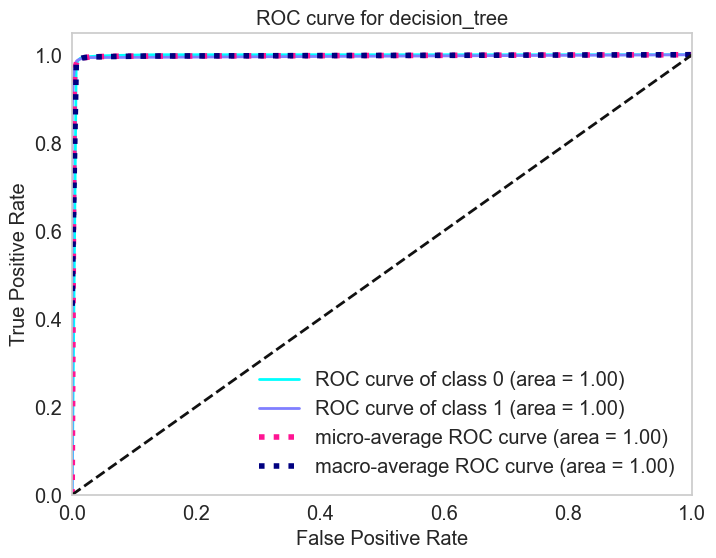

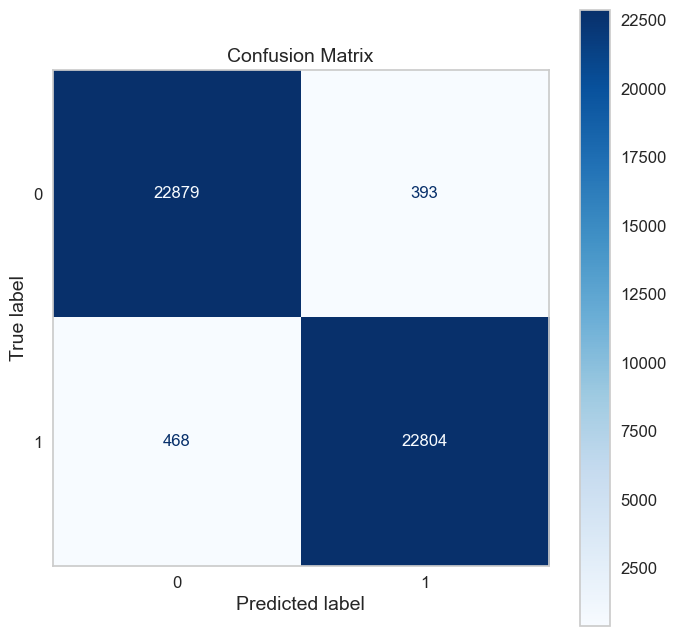

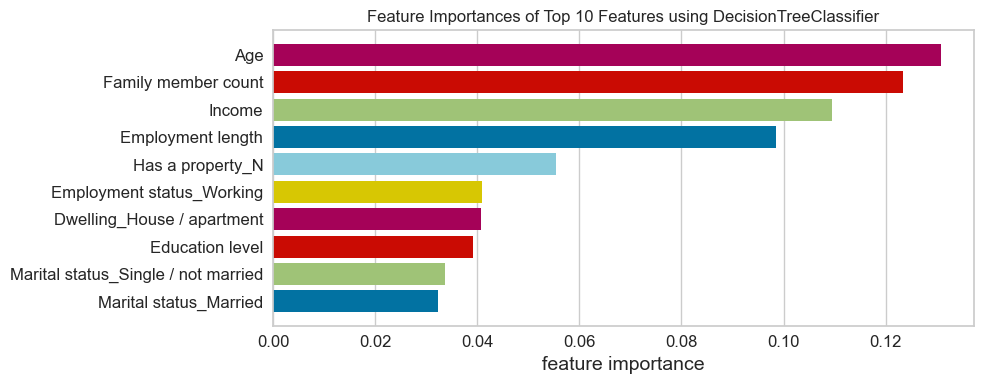

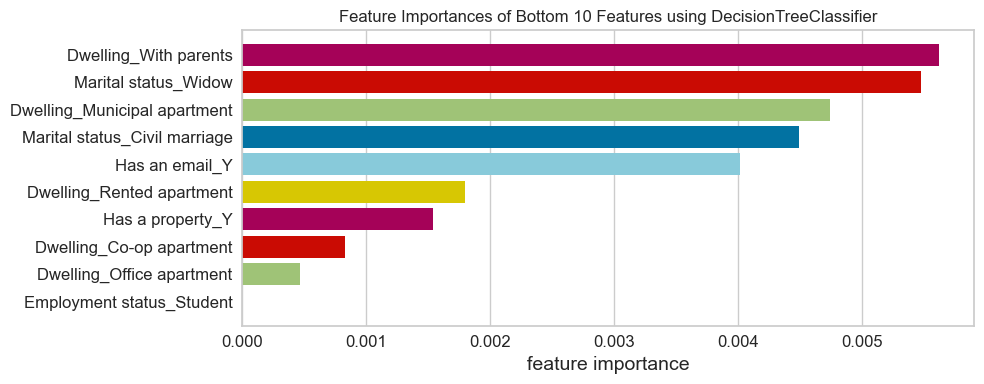

In [132]:
model_name =  'decision_tree'
model = DecisionTreeClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")






----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



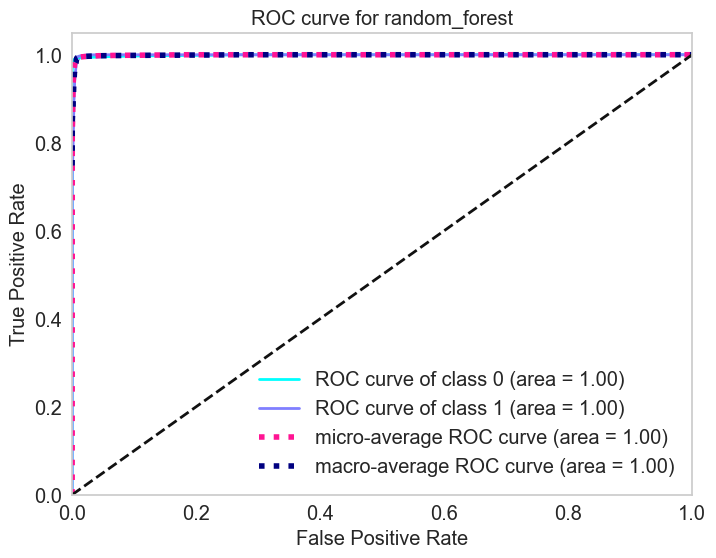

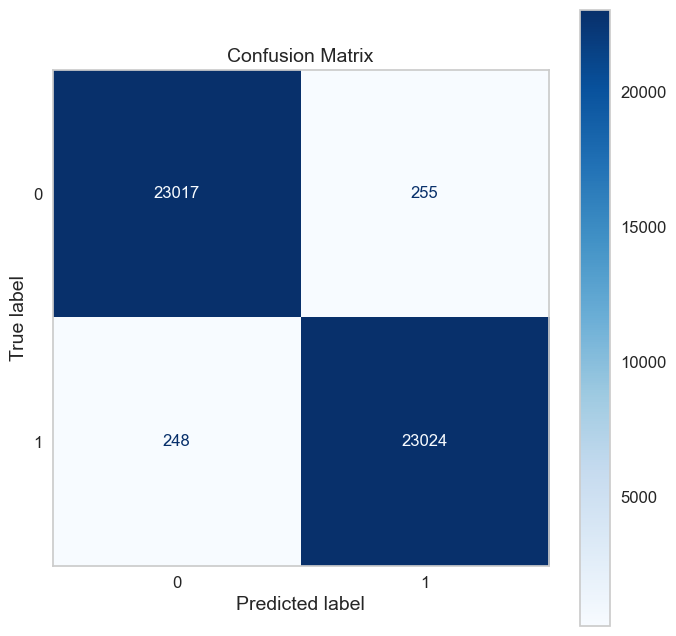

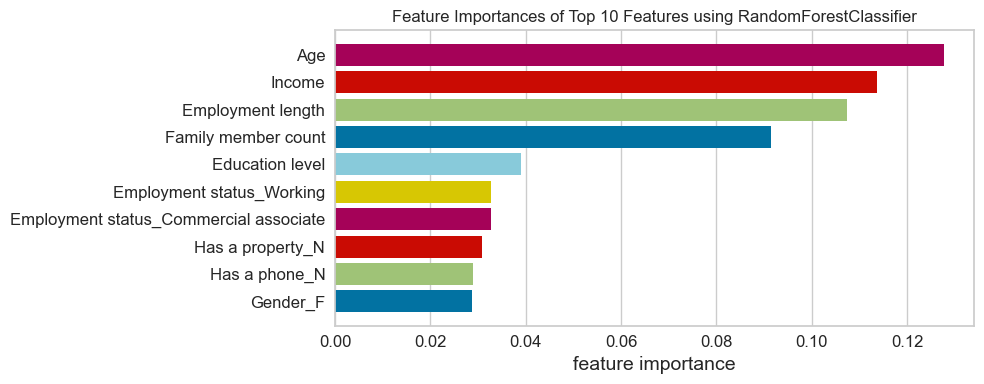

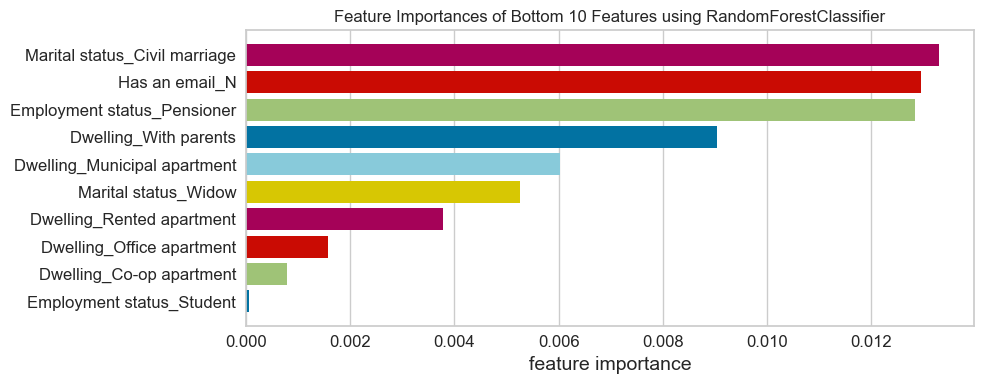

In [133]:
model_name = 'random_forest'
model = RandomForestClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.55      0.57     23272
           1       0.58      0.61      0.60     23272

    accuracy                           0.58     46544
   macro avg       0.58      0.58      0.58     46544
weighted avg       0.58      0.58      0.58     46544



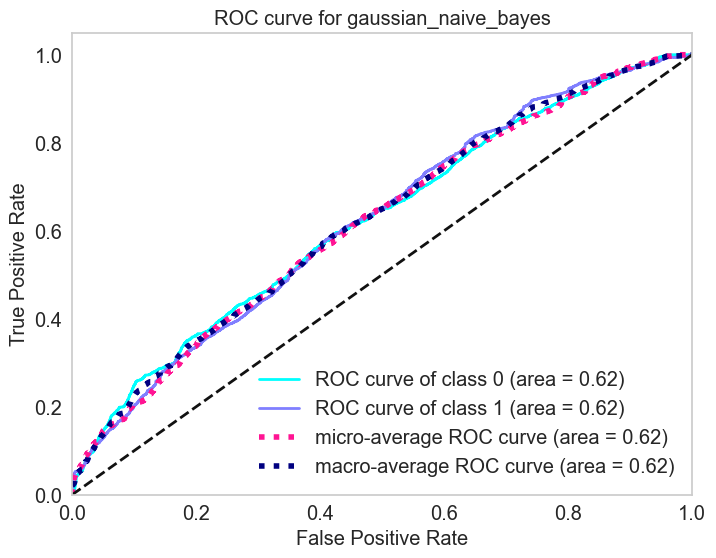

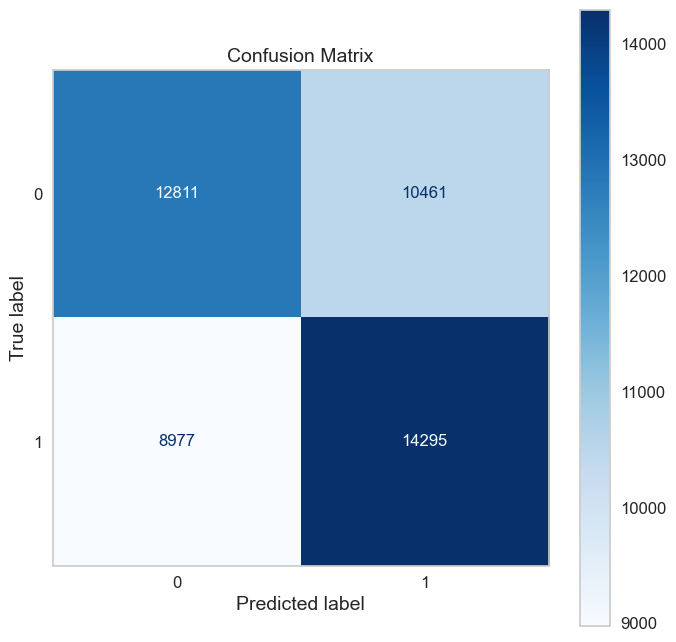



No feature importance for gaussian_naive_bayes




In [134]:
model_name =  'gaussian_naive_bayes'
model = GaussianNB()
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.93      0.96      0.95     23272
           1       0.96      0.93      0.94     23272

    accuracy                           0.94     46544
   macro avg       0.95      0.94      0.94     46544
weighted avg       0.95      0.94      0.94     46544



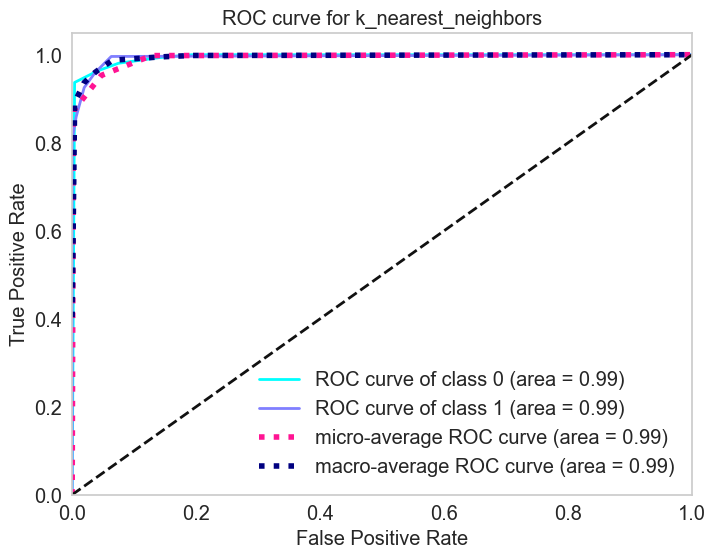

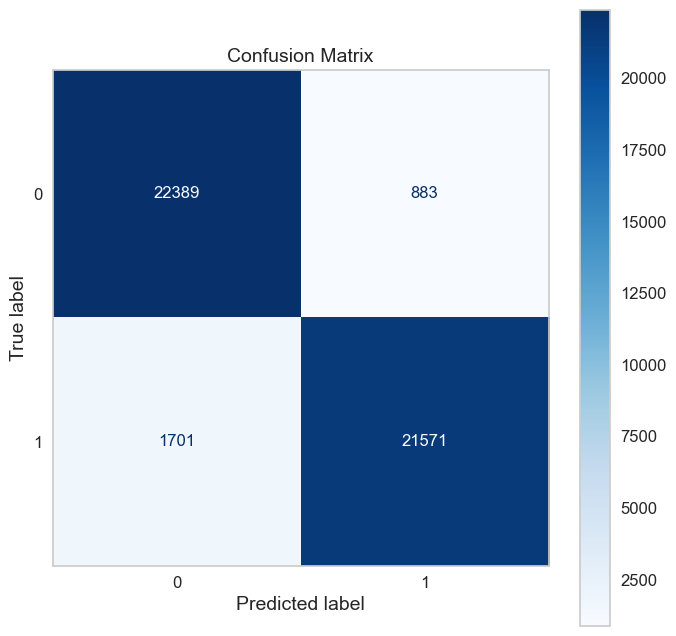



No feature importance for k_nearest_neighbors




In [135]:
model_name = 'k_nearest_neighbors'
model = KNeighborsClassifier()
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     23272
           1       0.90      0.90      0.90     23272

    accuracy                           0.90     46544
   macro avg       0.90      0.90      0.90     46544
weighted avg       0.90      0.90      0.90     46544



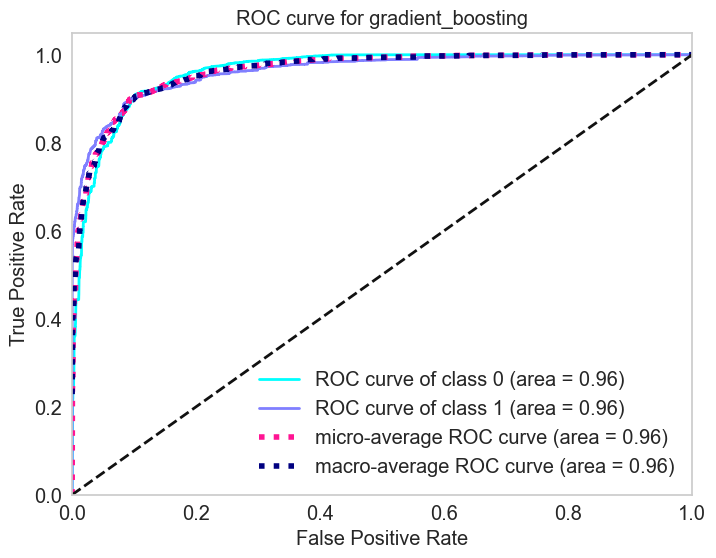

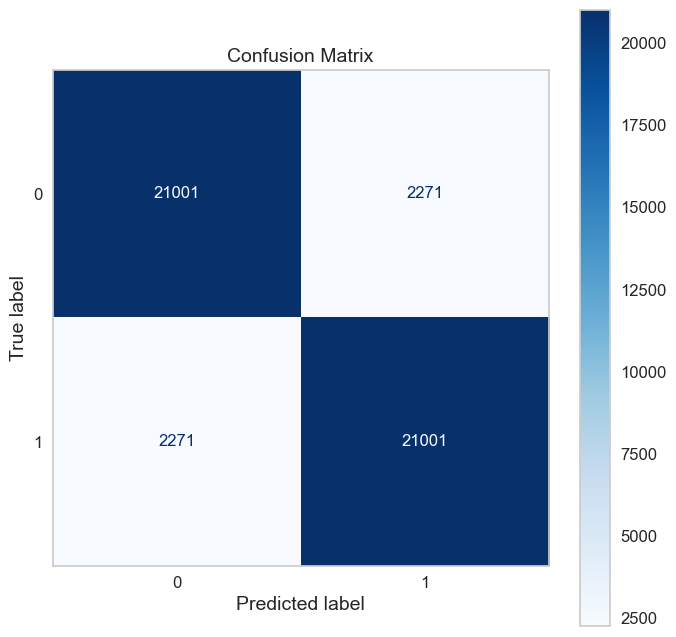

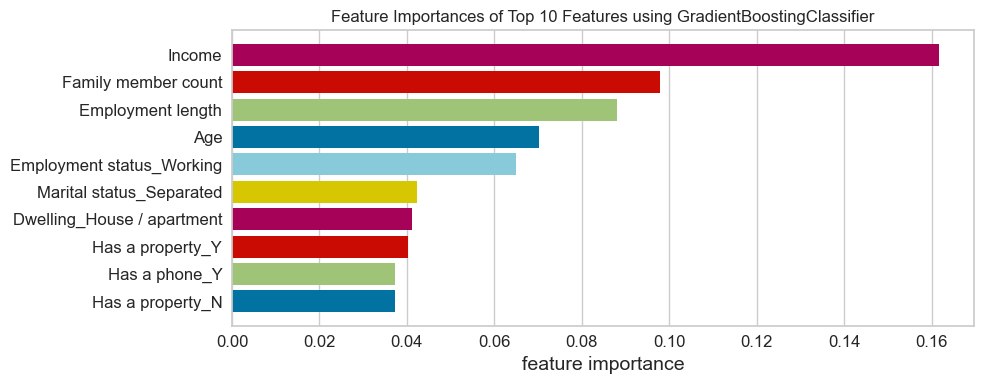

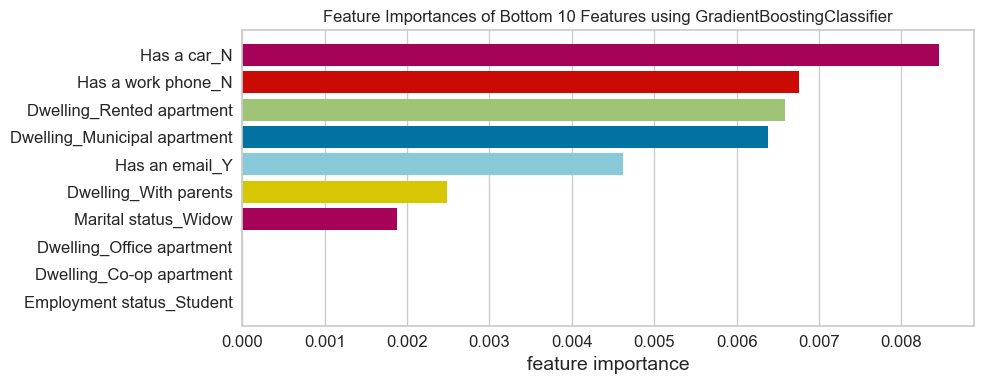

In [136]:
model_name = 'gradient_boosting'
model = GradientBoostingClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.59      0.56      0.57     23272
           1       0.58      0.62      0.60     23272

    accuracy                           0.59     46544
   macro avg       0.59      0.59      0.59     46544
weighted avg       0.59      0.59      0.59     46544



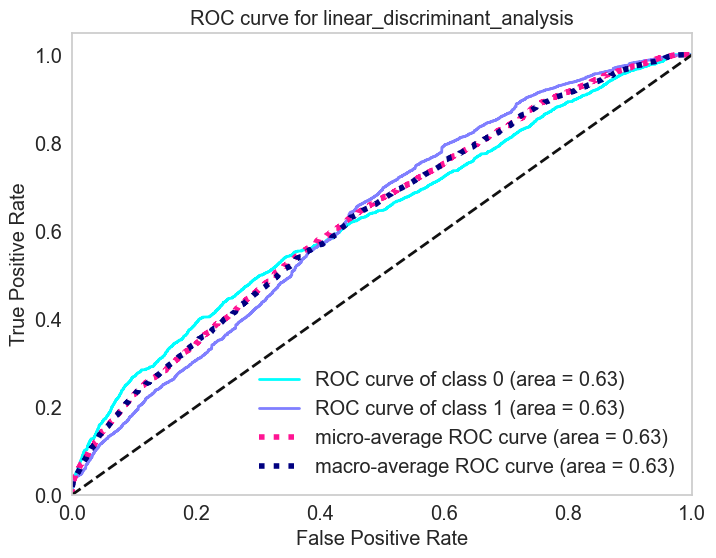

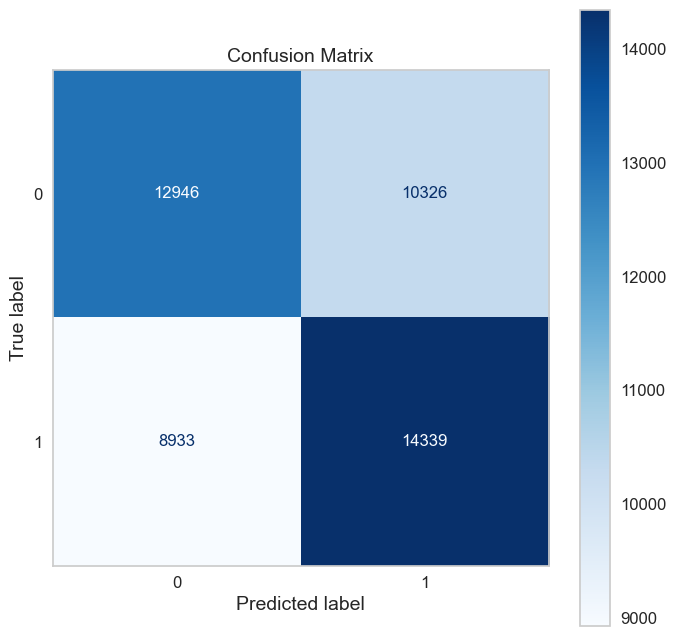

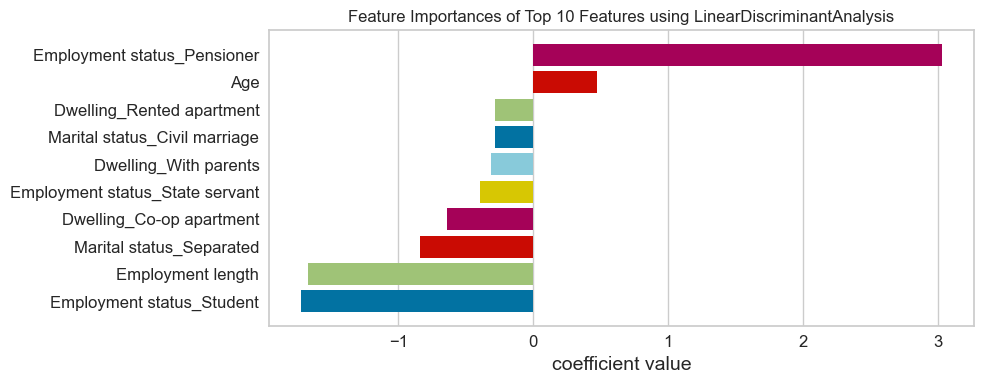

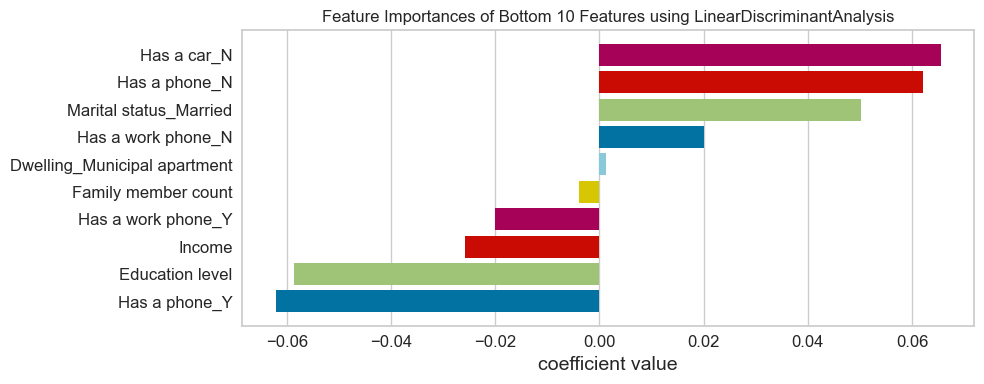

In [137]:
model_name = 'linear_discriminant_analysis'
model = LinearDiscriminantAnalysis()
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



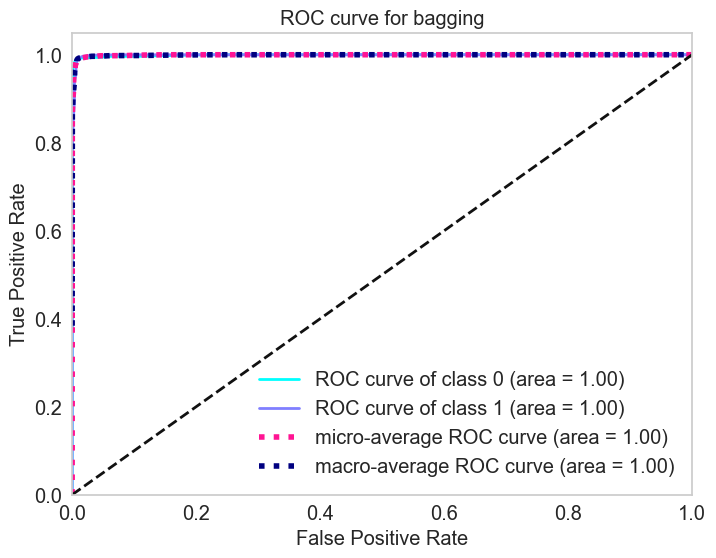

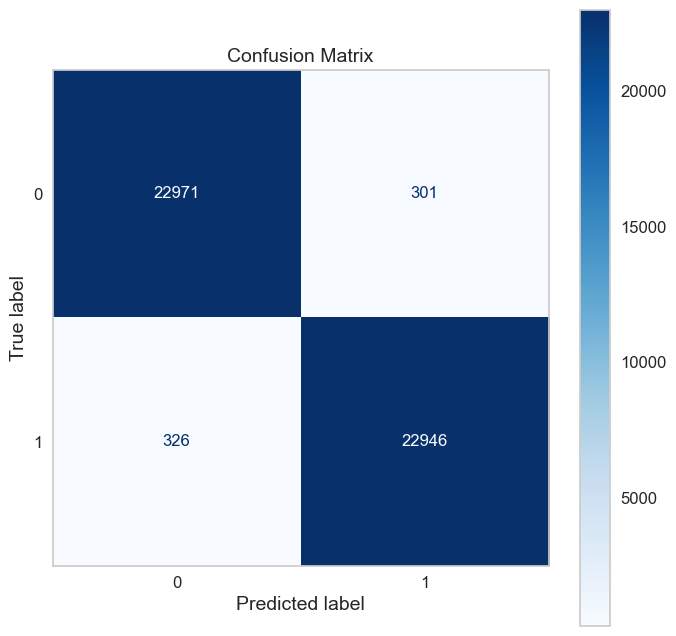



No feature importance for bagging




In [138]:
model_name = 'bagging'
model = BaggingClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.96      0.94      0.95     23272
           1       0.95      0.96      0.95     23272

    accuracy                           0.95     46544
   macro avg       0.95      0.95      0.95     46544
weighted avg       0.95      0.95      0.95     46544



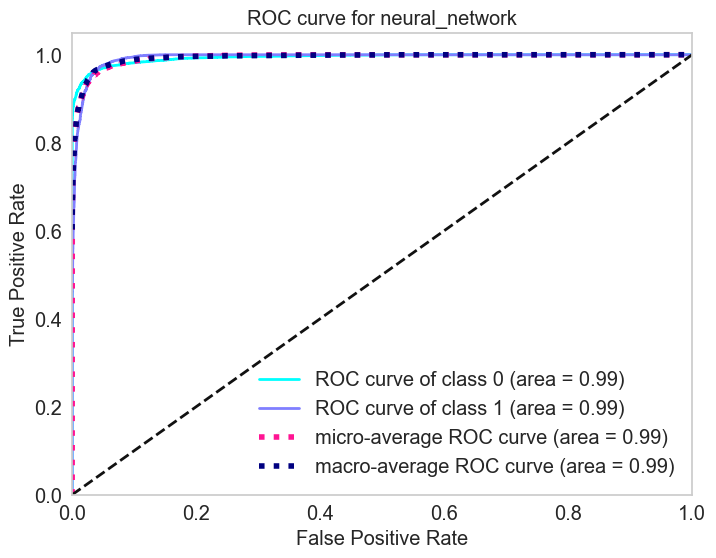

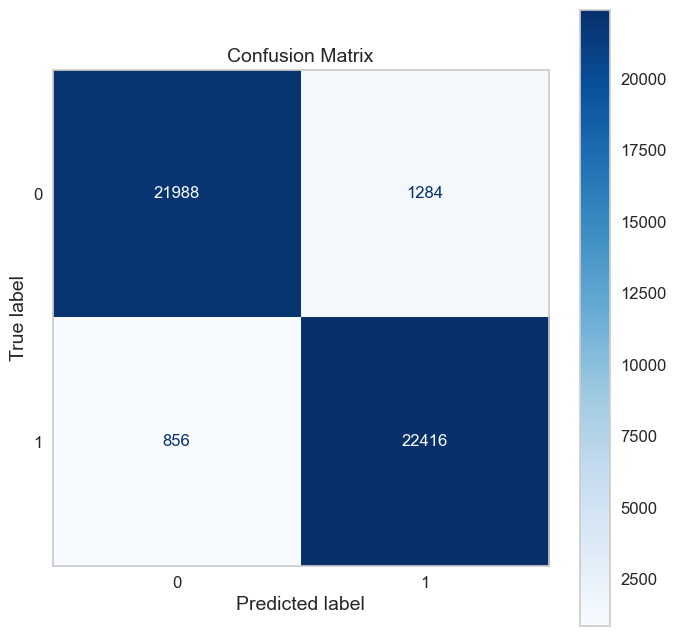



No feature importance for neural_network




In [139]:
model_name = 'neural_network'
model = MLPClassifier(random_state=42,max_iter=1000)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.77      0.75      0.76     23272
           1       0.75      0.77      0.76     23272

    accuracy                           0.76     46544
   macro avg       0.76      0.76      0.76     46544
weighted avg       0.76      0.76      0.76     46544



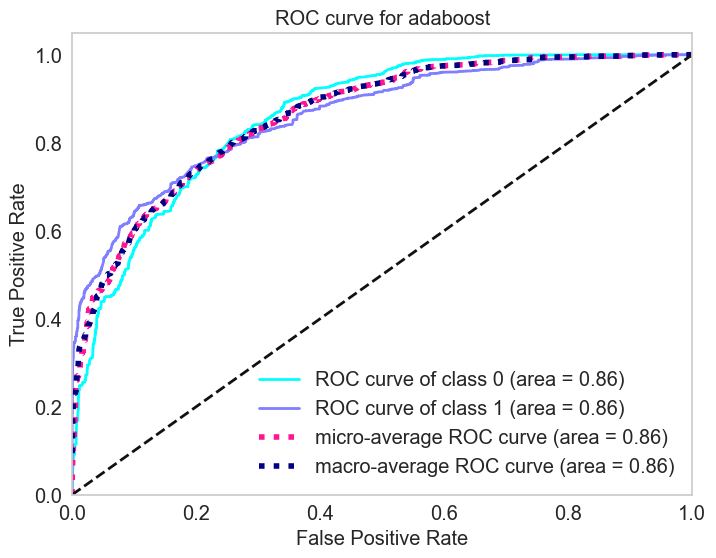

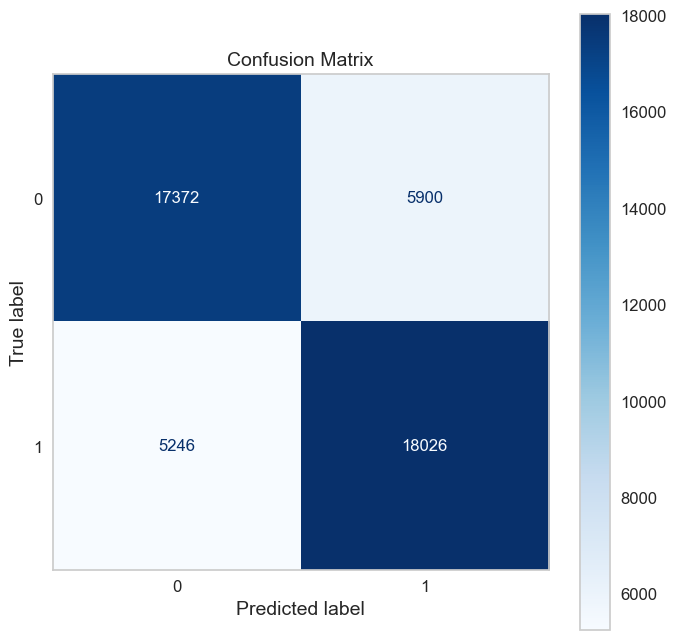

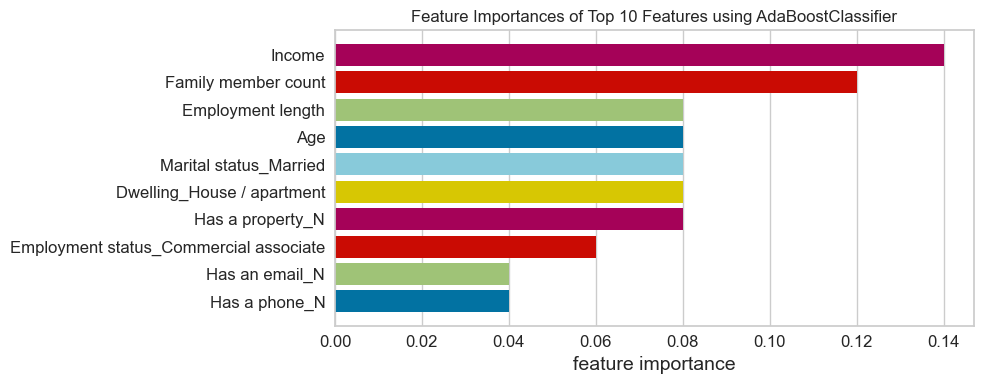

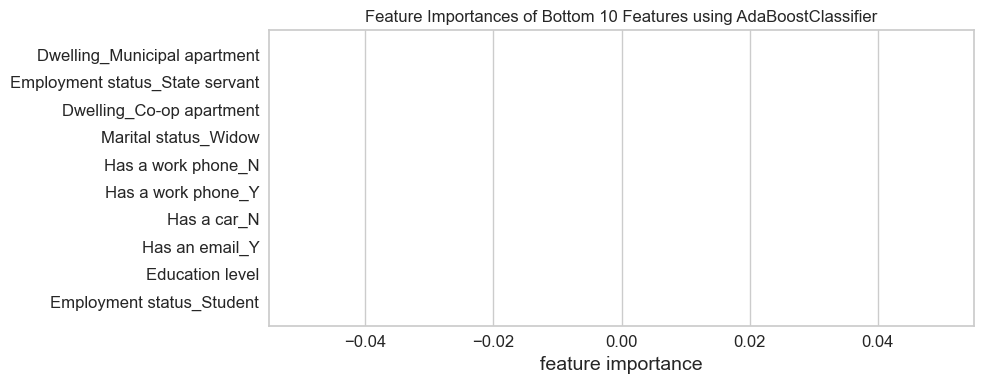

In [140]:
model_name = 'adaboost'
model = AdaBoostClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")





----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



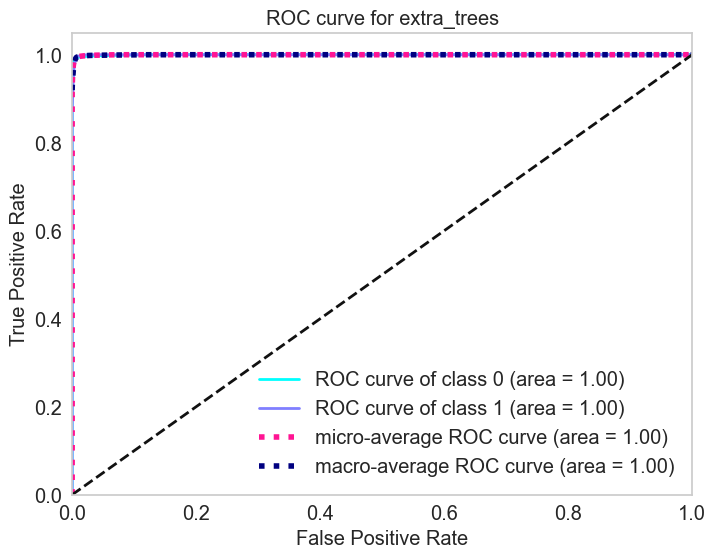

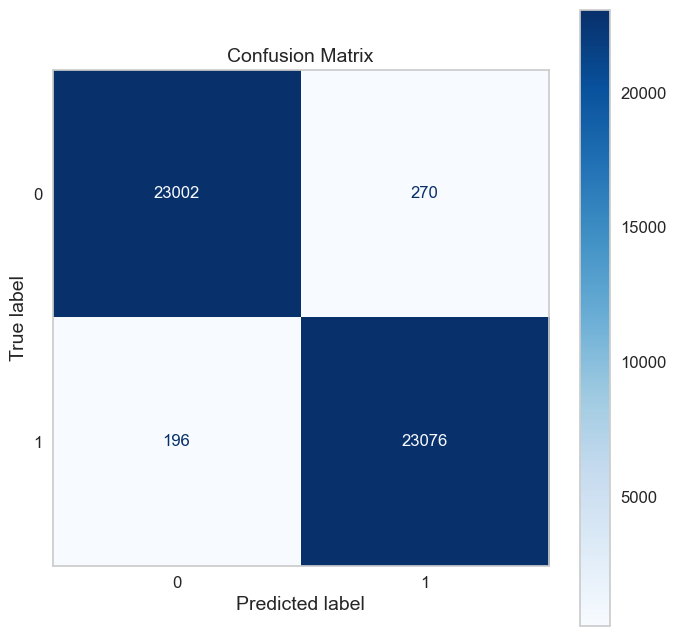

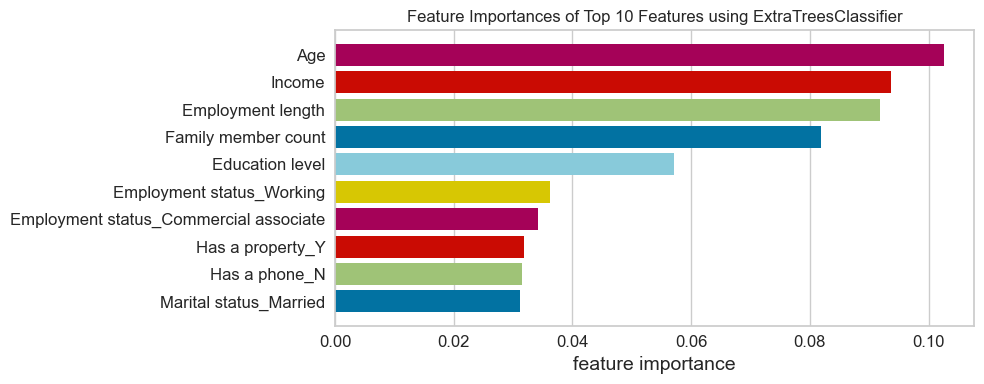

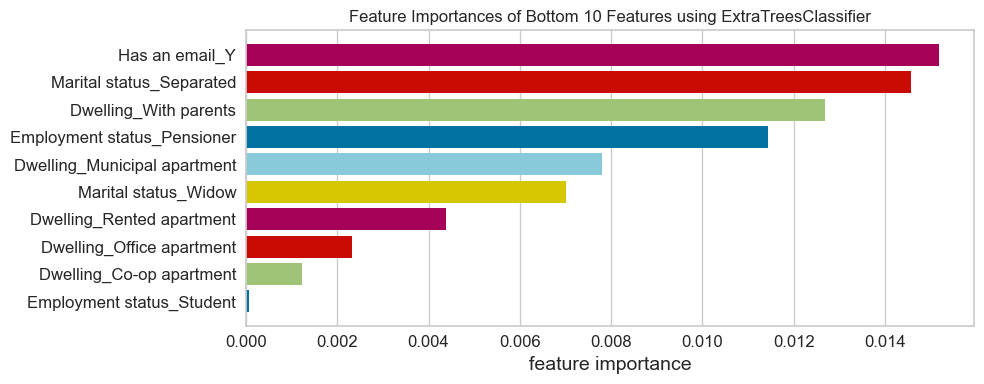

In [141]:
model_name = 'extra_trees'
model = ExtraTreesClassifier(random_state=42)
print('\n')
print('\n')
print('  {}  '.center(50,'-').format(model_name))
print('\n')
folder_check_model()
model_trn = train_model(model, model_name)
score_func(model_trn, model_name)
roc_curve_func(model_trn, model_name)
confusion_matrix_func(model_trn, model_name)
feat_importance_plot(model_trn, model_name)
warnings.filterwarnings("ignore")

### Top model

Using the ROC curve and recall, i can conclude that the best model is:
   Gradient boosting classifier

With this ROC curve, i can compare the performance of different classifiers. The closer the curve is to the top left corner of the plot without actually reaching the far end of the corner, the better the model

### Test the final model on the test set

Now with model trained, i can use it to predict the classes on the test set.

In [142]:
cc_test_copy.head(5)

ID Gender Has a car Has a property  Children count    Income  \
0  5091261      F         N              Y               0 202500.00   
1  5096963      M         Y              N               0 675000.00   
2  5087880      F         N              N               0 234000.00   
3  5021949      F         Y              Y               0 445500.00   
4  5105705      F         Y              N               0 225000.00   

      Employment status                Education level  Marital status  \
0         State servant  Secondary / secondary special       Separated   
1  Commercial associate               Higher education         Married   
2         State servant               Higher education  Civil marriage   
3  Commercial associate               Higher education         Married   
4               Working  Secondary / secondary special         Married   

              Dwelling    Age  Employment length  Has a mobile phone  \
0    House / apartment -16834              -1692                   1   
1    House / apartment -18126               -948                   1   
2    House / apartment -21967              -5215                   1   
3    House / apartment -12477               -456                   1   
4  Municipal apartment -12155               -667                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 0            0             0  Medicine staff   
1                 0            1             0        Managers   
2                 0            0             1      Core staff   
3                 0            0             0        Managers   
4                 0            0             0        Laborers   

   Family member count  Account age  Is high risk  
0                 1.00        -6.00             0  
1                 2.00       -16.00             0  
2                 2.00       -52.00             0  
3                 2.00       -54.00             0  
4                 2.00       -48.00             0

I pass to the scikit-learn pipeline the test set as i did before for the training set to obtain a preprocessed dataset ready for our model.

In [143]:
cc_test_prep = full_pipeline(cc_test_copy)

I extract the independent variables/features and the target variable and store them into variables X_cc_test_prep and y_cc_test_prep respectively.

In [144]:
X_cc_test_prep, y_cc_test_prep = cc_test_prep.loc[:, cc_test_prep.columns != 'Is high risk'], cc_test_prep['Is high risk'].astype('int64')

Next train the model

In [145]:
classifiers = {'gradient_boosting':GradientBoostingClassifier(random_state=42)}
model_trn = train_model(classifiers['gradient_boosting'],'gradient_boosting')

Then predict the dependent variable (predicted target) and store the prediction in the final_prediction variable.

In [146]:
final_predictions = model_trn.predict(X_cc_test_prep)

The shape method to get the number of rows and columns.

In [147]:
final_predictions.shape

(11654,)

I use the sum function to compare the predictions and actual target values. I store the count of the correct predictions in n_correct

In [148]:
n_correct = sum(final_predictions == y_cc_test_prep)

I divide the number of correct predictions by the total number of predictions to get the accuracy.

In [149]:
print(n_correct/len(final_predictions))

0.845718208340484


Achieved 84% accuracy on the testing set.